1. cell type 
2. coarse cell type

check elbo between wrong and correct ones

In [1]:
%cd /home/mffang/workspace/Poisson-regression

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)
from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixtureSS, PoissonMixture, GammaPoissonMixture
from RADOM.plotting import *

/home/mffang/workspace/Poisson-regression
2023.09.01


In [50]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

In [3]:
import numpy.ma as ma

def plot_cor(A,B):
    a = ma.masked_invalid(A)
    b = ma.masked_invalid(B)
    msk = (~a.mask & ~b.mask)
    X = A[msk]
    Y = B[msk]
    plt.loglog(A[msk],A[msk],'k')
    plt.plot(A[msk],B[msk],'.', \
           label="CCC="+str(np.round(CCC(X,Y),2))\
             +"\nPearson's r="+str(np.round(np.corrcoef(X,Y)[0,1],2)));
    plt.legend(fontsize=15)

In [4]:
plt.rcParams['font.size'] = '24'
plt.rcParams['lines.linewidth'] = 12
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '30'
legend_font = '24'
title_font = '36'

color_palette = ["#d1e2e5","#a2c5ca","#458b94","#2a606b","#0e3442"]
cmap_teal = LinearSegmentedColormap.from_list("Teals", color_palette, N=7)

# EDA

## Load counts

h5 files can be downloaded as following:
```
#!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_for_velocity_mouse.h5
#!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_human_for_velocity.h5
```

In [5]:
adata = sc.read('./data/erythroid_lineage.h5ad')
gene_names = adata.var_names
x = adata.obsm['X_pca']
x[:,0] *= -1
adata

AnnData object with n_obs × n_vars = 9815 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

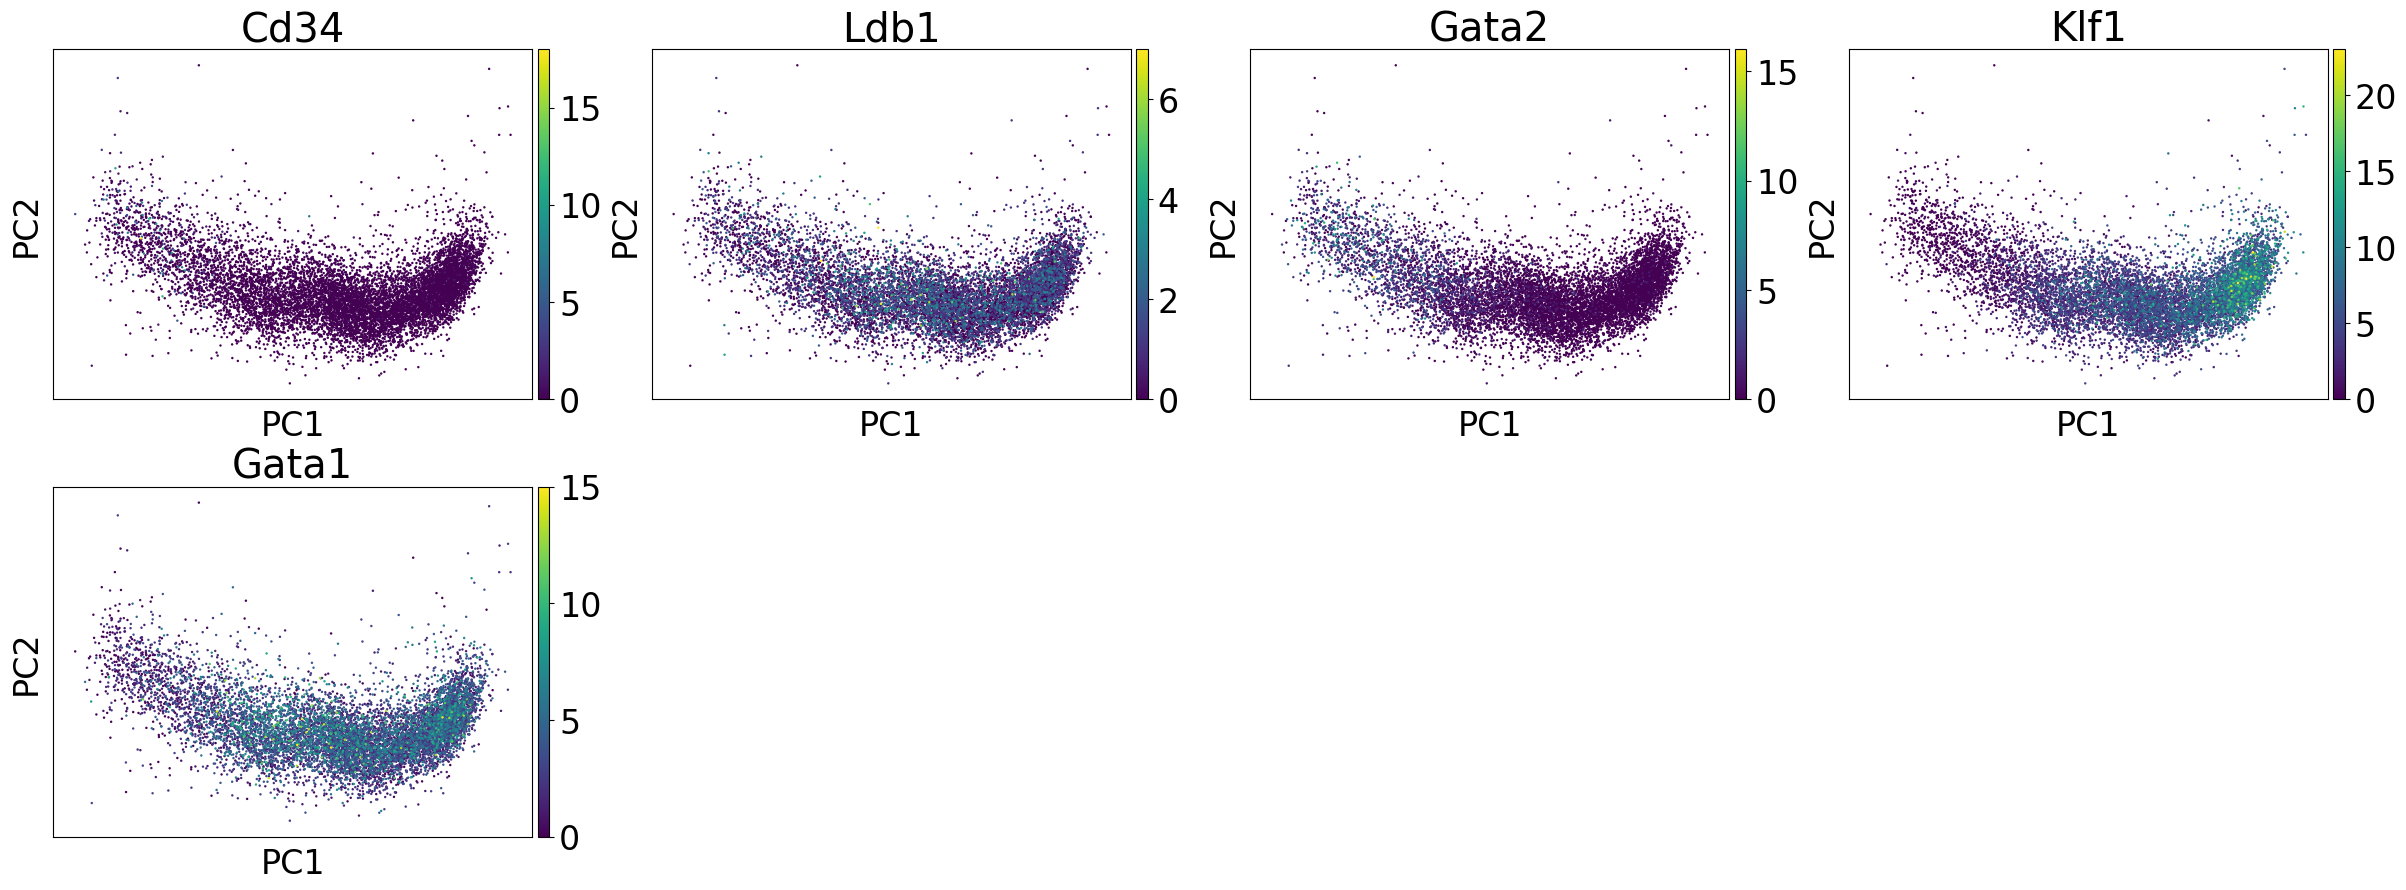

In [6]:
plot_marker_genes = ['Cd34','Gata1','Klf1','Gata2','Ldb1']
# Spn==Cd43
sc.pl.pca(adata,color=adata.var_names[adata.var_names.isin(plot_marker_genes)])

In [170]:
clusters = adata.obs["celltype"]
Clusters = ['Blood progenitors 1','Blood progenitors 2','Erythroid1','Erythroid2', 'Erythroid3']
cell_types = ['Blood progenitors 1','Blood progenitors 2','Erythroid1','Erythroid2', 'Erythroid3']
celltype_colors = ["#f29696","#d96f6f","#ce535a","#c23645","#941524"]


from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", celltype_colors, N=5)

Blood progenitors 1 623
Blood progenitors 2 2460
Erythroid1 2929
Erythroid2 1106
Erythroid3 2697


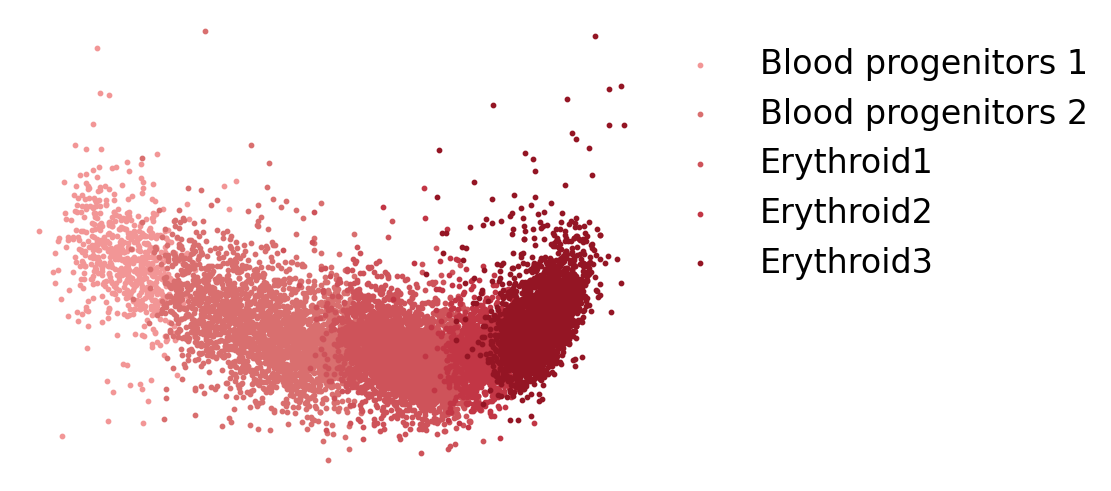

In [406]:
fig, ax = plt.subplots(1,1,figsize=(11,4.8))
for i,cell_type in enumerate(cell_types):
    idx = adata.obs['celltype'].isin([cell_type])
    print(cell_type,idx.sum())
    im=ax.scatter(x[idx,0],x[idx,1],c=celltype_colors[i],label=cell_type,s=10);
#ax.set_xlabel('PC1',fontsize=label_font)
#ax.set_ylabel('PC2',fontsize=label_font)
ax.set_frame_on(False)
ax.legend(loc=(1,0.4),fontsize=legend_font,frameon=False)
plt.xticks([]);
plt.yticks([]);

In [9]:
cell_types = ['Blood progenitors 1','Blood progenitors 2','Erythroid1','Erythroid2', 'Erythroid3']
cell_colors = np.empty((adata.n_obs),dtype=object)

for i,cell_type in enumerate(cell_types):
    idx = adata.obs['celltype'].isin([cell_type])
    cell_colors[idx]=celltype_colors[i]


Stages = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']
cmap_teal = LinearSegmentedColormap.from_list("Teals", color_palette, N=7)

Stage_cell_colors = np.empty((adata.n_obs,4))
for i,Stage in enumerate(Stages):
    idx = adata.obs['stage'].isin([Stage])
    Stage_cell_colors[idx]=cmap_teal(i)
Stage_cell_colors[:,-1]*=0.5

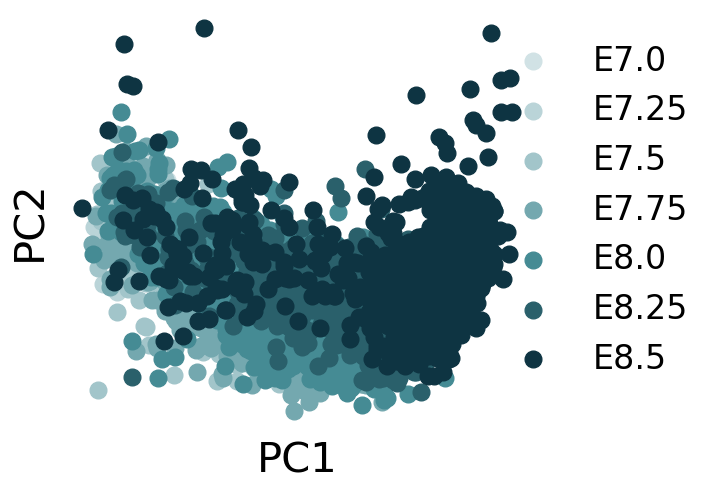

In [10]:
color_palette = ["#d1e2e5","#BAD4D8","#a2c5ca","#74A8AF","#458b94","#2a606b","#0e3442"]
cmap_teal = LinearSegmentedColormap.from_list("Teals", color_palette, N=7)

fig, ax = plt.subplots(1,1,figsize=(7,4.8))
for i,Stage in enumerate(Stages):
    idx = adata.obs['stage'].isin([Stage])
    im=ax.scatter(x[idx,0],x[idx,1],color=cmap_teal(i),label=Stage);
ax.set_xlabel('PC1',fontsize=label_font)
ax.set_ylabel('PC2',fontsize=label_font)
ax.set_frame_on(False)
ax.legend(loc=(0.9,0.1),fontsize=legend_font,frameon=False)
plt.xticks([]);
plt.yticks([]);

## Gene variance

0.012088963 0.24082643


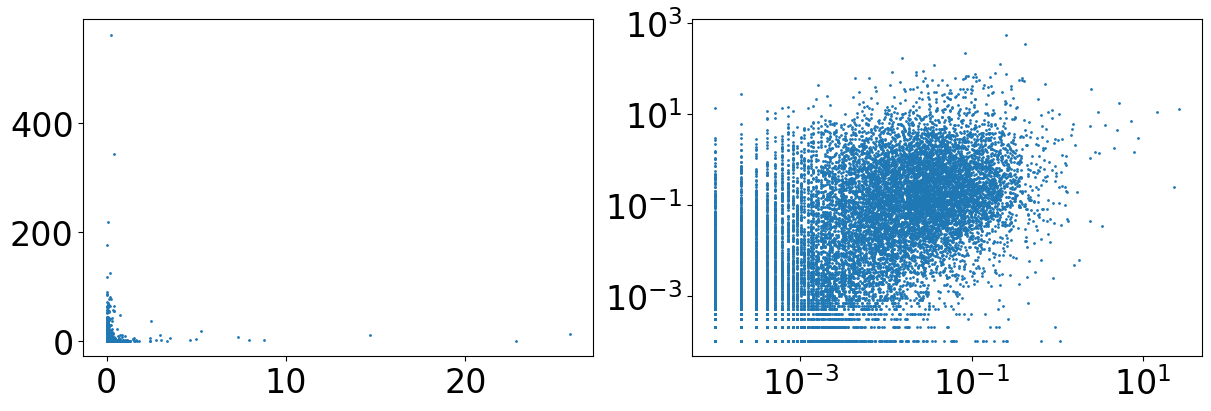

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

In [12]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0) & (adata.layers["unspliced"].toarray().mean(0) > 0)

U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))

S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.27032174405225184
s estimated by normalized covariance of total S counts = 0.2403856987393963
s estimated by normalized covariance of total counts = 0.22013451402941459
s estimated by total counts = 0.11305980106288614


In [13]:
a=1
sp=s1

X_bar = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
for i in range(5):
    Pgene_mask = (X_mean > 0.01) & (X_var/(a*X_mean + sp*X_mean**2) < 1.2)   
    P = (S + U)[:,Pgene_mask]
    n,p = P.shape
    P_cov = np.cov(P,rowvar=False)
    P_mean = np.mean(P,axis=0)
    P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
    sp = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
    print(Pgene_mask.mean(),"s:", str(sp))

0.624215428224337 s: 0.11460050425284946
0.5970169400013497 s: 0.11508050028762362
0.5974218802726597 s: 0.11504352159108108
0.5974218802726597 s: 0.11504352159108108
0.5974218802726597 s: 0.11504352159108108


Text(0.02, 0.5, 'CV$^2$')

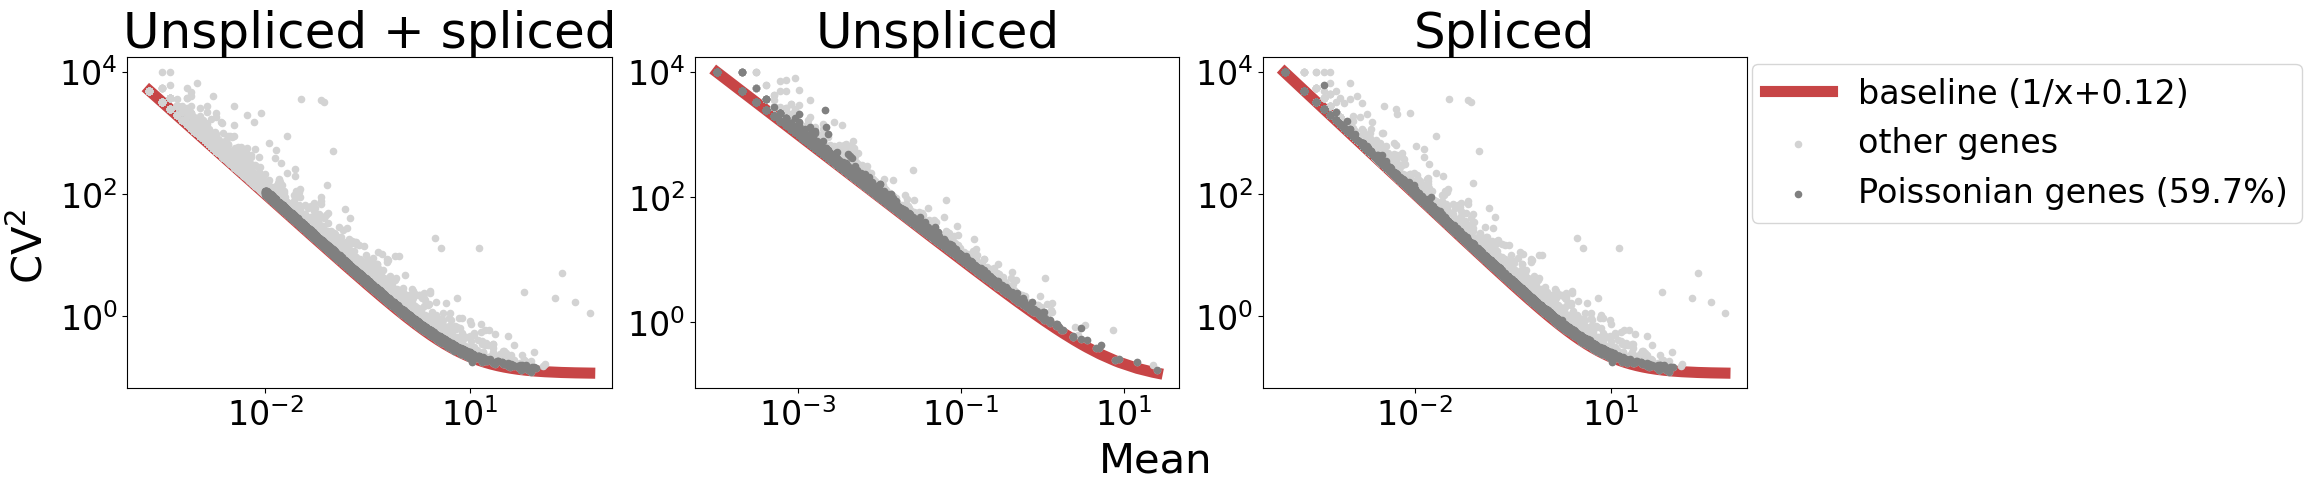

In [14]:
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

fig, ax = plt.subplots(1,3,figsize=(23,4.8))

ax[0].plot(np.sort(X_mean), a/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0)
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20)
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)

ax[1].plot(np.sort(U_mean), a/np.sort(U_mean) + sp, color='#c74546', linewidth=8, zorder=0)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20, label='other genes')
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)

ax[2].plot(np.sort(S_mean), a/np.sort(S_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20, label='other genes')
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)

ax[2].legend(loc=(1.01,0.5),fontsize=legend_font)
fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

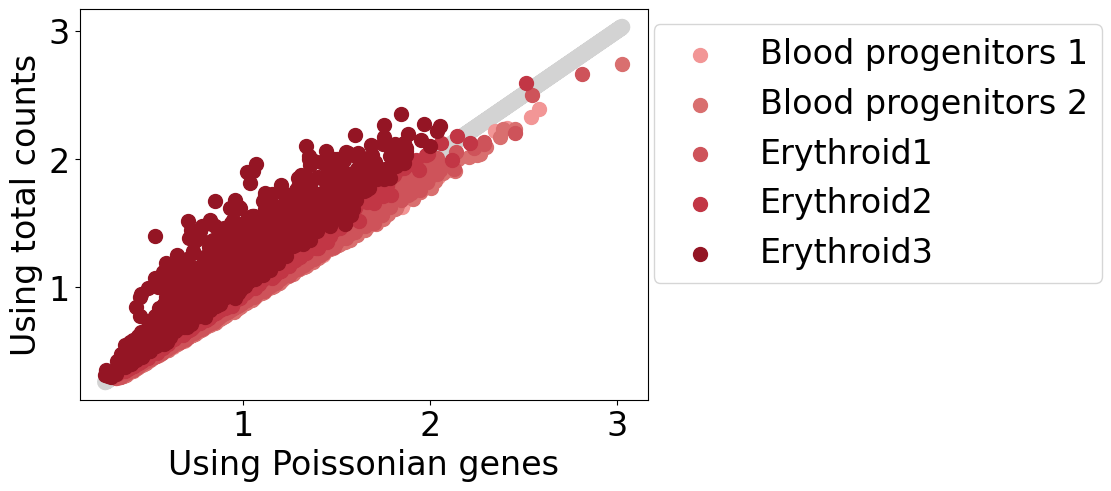

In [392]:
rd = (U + S)[:,Pgene_mask].mean(1)/(U + S)[:,Pgene_mask].mean()
rd_ = X_total/X_total.mean()
fig, ax = plt.subplots(1,1,figsize=(11,4.8))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    ax.scatter(rd[idx],rd_[idx],color=cmap_cluster(i),alpha=1,s=100,label=Cluster)
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)
plt.legend(loc=(1.01,0.3),fontsize=legend_font)

## Select genes

In [16]:
var_threshold = 1.2
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.02) & (S_mean > 0.1) \
    & (U_var/(a*U_mean + sp*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + sp*S_mean**2) > var_threshold) \
    & (np.abs(np.log(S_mean/U_mean)) < 4)
fitted_genes=adata.var_names[fitted_idx]
len(fitted_genes)

/tmp/ipykernel_1956412/3277366414.py:7: RuntimeWarning: invalid value encountered in divide
  & (U_var/(a*U_mean + sp*U_mean**2) > var_threshold) \
/tmp/ipykernel_1956412/3277366414.py:8: RuntimeWarning: invalid value encountered in divide
  & (S_var/(a*S_mean + sp*S_mean**2) > var_threshold) \
/tmp/ipykernel_1956412/3277366414.py:9: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_1956412/3277366414.py:9: RuntimeWarning: invalid value encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_1956412/3277366414.py:9: RuntimeWarning: divide by zero encountered in log
  & (np.abs(np.log(S_mean/U_mean)) < 4)


57

In [17]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
fitted_genes = fitted_genes[~fitted_genes.isin(cell_cycle_genes)]
len(fitted_genes)

51

49


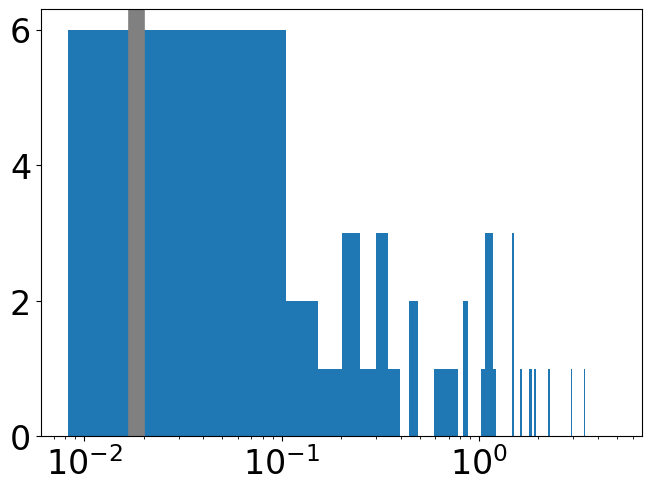

In [18]:
gene_length_file = np.loadtxt("data/gg_200524_mouse_genome_polyA_cum_1.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0] for gene in gene_length_file])

fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)
print(len(fitted_genes))

Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ])
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

In [19]:
idx1 = np.where(gene_name == 'Hba-x')[0][0]
idx2 = np.where(adata.var_names == 'Hba-x')[0][0]

adata.layers["unspliced"][:,idx2].mean()/adata.layers["spliced"][:,idx2].mean()/(10**(-5)*gene_length[idx1])

0.0709651461674956

/tmp/ipykernel_1956412/3805144832.py:3: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=10)
/tmp/ipykernel_1956412/3805144832.py:4: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(S_mean, a/S_mean + sp, c='#c74546', alpha=0.5, s=20)
/tmp/ipykernel_1956412/3805144832.py:11: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=10, label='other genes')
/tmp/ipykernel_1956412/3805144832.py:12: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter(U_mean, a/U_mean + sp, c='#c74546', alpha=0.5, s=20, label='variance baseline')


Text(0.02, 0.5, 'Variance')

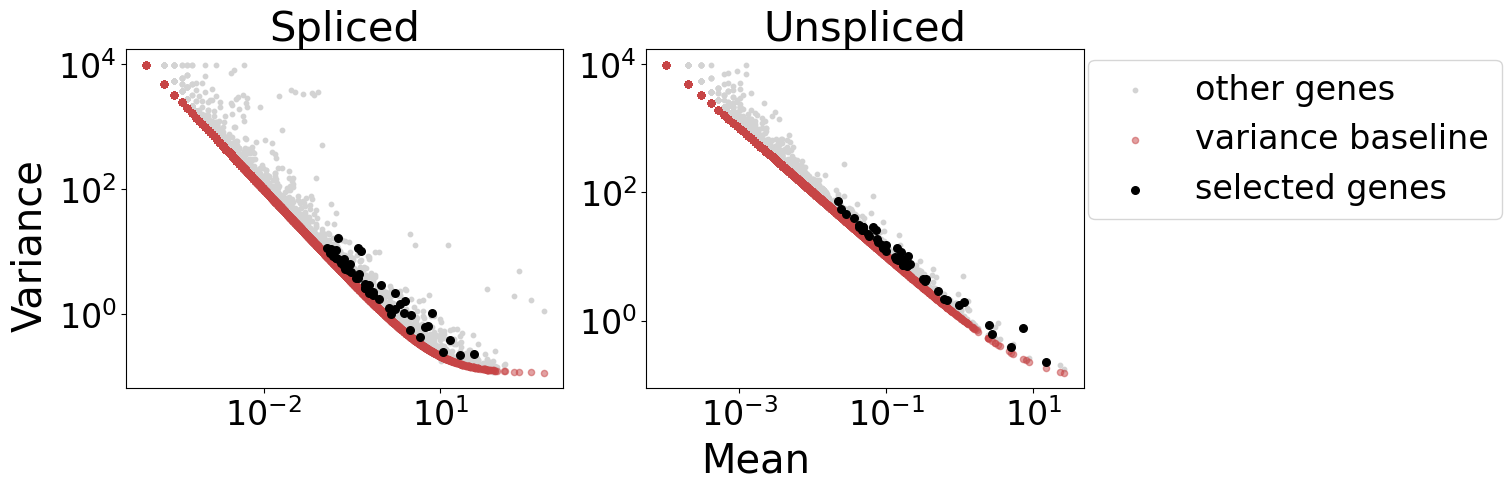

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,4.8))

ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=10)
ax[0].scatter(S_mean, a/S_mean + sp, c='#c74546', alpha=0.5, s=20)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, s=30, c='k')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Spliced',fontsize=label_font)


ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=10, label='other genes')
ax[1].scatter(U_mean, a/U_mean + sp, c='#c74546', alpha=0.5, s=20, label='variance baseline')
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, s=30, c='k', label='selected genes')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(loc=(1.01,0.5),fontsize=legend_font)
ax[1].set_title('Unspliced',fontsize=label_font)
fig.supxlabel('Mean')
fig.supylabel('Variance')

In [21]:
fitted_idx = adata.var_names.isin(fitted_genes)

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
print(X.mean((0,1)))
X.shape

[0.83096676 2.82106314]


(9815, 49, 2)

In [22]:
marker_genes = ['Smim1','Hba-x','Abcg2','Cnn3','Scube2','Klf1','Gata2','Gata2','Cd45']
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['Smim1', 'Abcg2', 'Cnn3'], dtype='object', name='index')


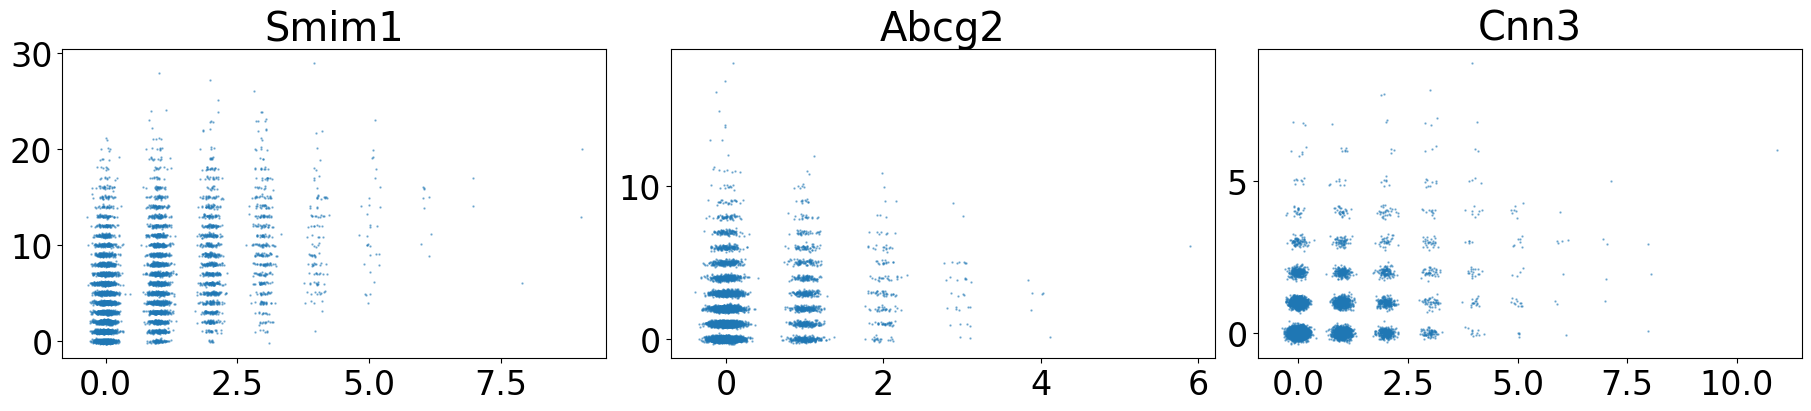

In [23]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

## Mixtures fitting

1 -105.75387343067196 -105.76385814794145 -105.79976152931982
2 -97.80339229847891 -97.81847125925324 -97.87269269235529
3 -95.24186110223883 -95.26203430651799 -95.3345737913437
4 -94.11722020555028 -94.14248765333429 -94.23334518988366
5 -93.57830806667661 -93.60866975796546 -93.71784534623849
6 -93.15051190799367 -93.18596784278736 -93.31346148278406


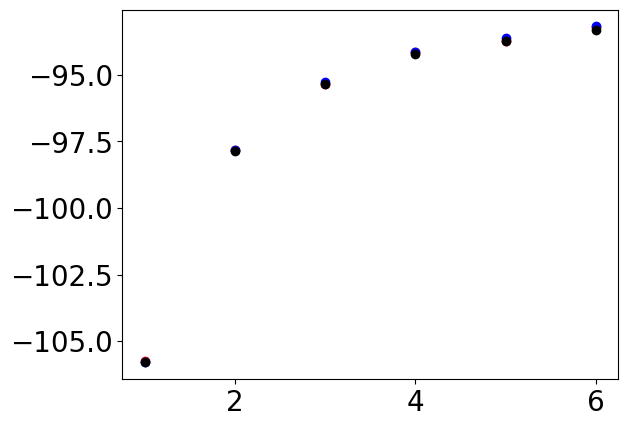

In [32]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixtureSS(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    plt.scatter(nc,elbo,color='r')
    plt.scatter(nc,PM.compute_AIC(X),color='b')
    plt.scatter(nc,PM.compute_BIC(X),color='k')
    print(nc,PM.compute_lower_bound(X),PM.compute_AIC(X),PM.compute_BIC(X))

In [24]:
PM = PoissonMixtureSS(n_components=3,verbose=0)
Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=10,n_init=5)
PM.weights

array([0.35848442, 0.19144596, 0.45006962])

In [25]:
cluster_gene_logL, cluster_KL = PM.compute_gene_logL(X,Q)
cluster_KL 

-0.9916697032724092

In [26]:
PM.elbo = elbo
PM.Q = Q

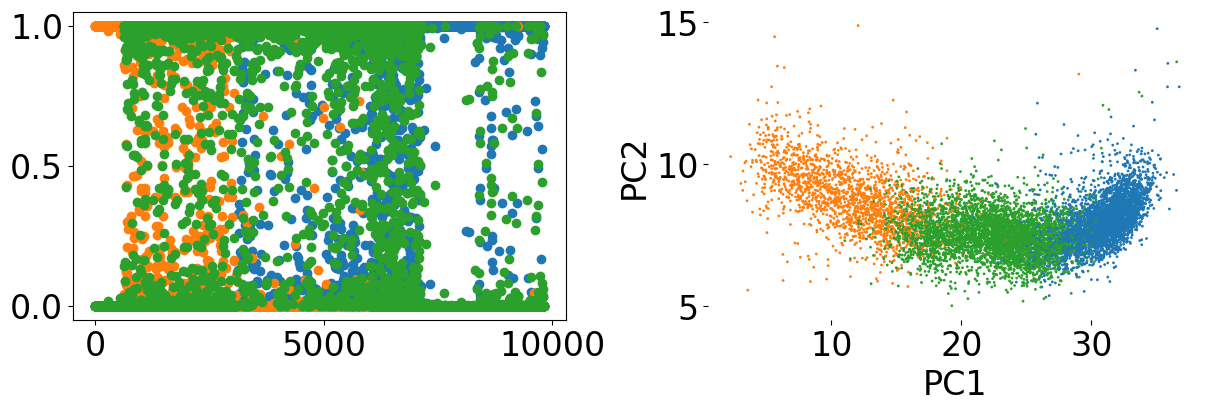

In [27]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters)],'.');
ax[1].scatter(x[:,0],x[:,1],c=tab_colors[np.argmax(Q,axis=-1)],s=1);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

In [28]:
PM_elbo = elbo

# Trajectory fitting

In [30]:
params_Ub={'r':rd,"Ub":Ub,"lambda_tau":0,"lambda_a":0}
params={'r':rd,"lambda_tau":0,"lambda_a":0}

topo = np.array([[0,1,2]])
tau = (0,1,2) # ~48 hours

In [31]:
with open('results/Erythoid.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    data = pickle.load(f)

traj_ws = data['ws']
trajs = data['ri']
X = traj_ws.X.copy()
rd = traj_ws.params['r']
PM = data['PM']

## Warm start

In [184]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,cell_type in enumerate(cell_types):
    idx = clusters.isin([cell_type])
    weight0[idx,int(i*m/len(cell_types)):int((i+1)*m/len(cell_types))] += 1
weight0 = weight0/weight0.sum(axis=1,keepdims=True)
Q0 = weight0[:,None]

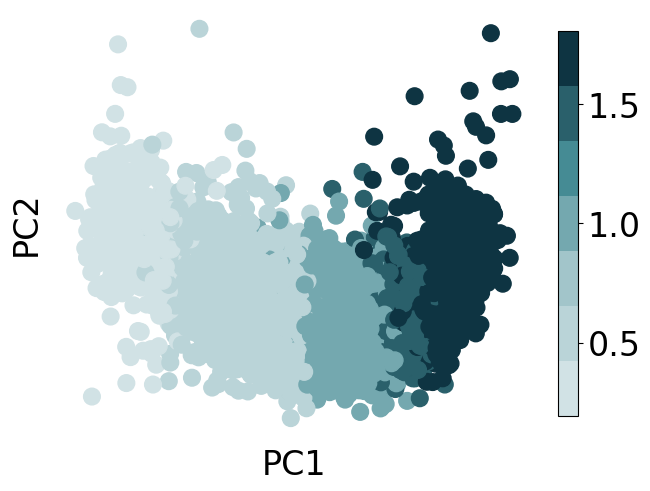

In [185]:
ref_t = weight0@(np.linspace(0,2,m).reshape((-1,1)))
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=ref_t,cmap=cmap_teal);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [186]:
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params={'r':rd/rd.mean()},Q=Q0,parallel=True,n_threads=10,epoch=100)
gene_logL, KL = traj.compute_gene_logL(traj.X,traj.Q)
print(traj.elbos[-1])

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 100/100 [04:28<00:00,  2.69s/it]


-94.47986899235524


In [187]:
traj_ws = copy.deepcopy(traj)

In [179]:
traj = copy.deepcopy(traj_ws)

-94.15728890899835


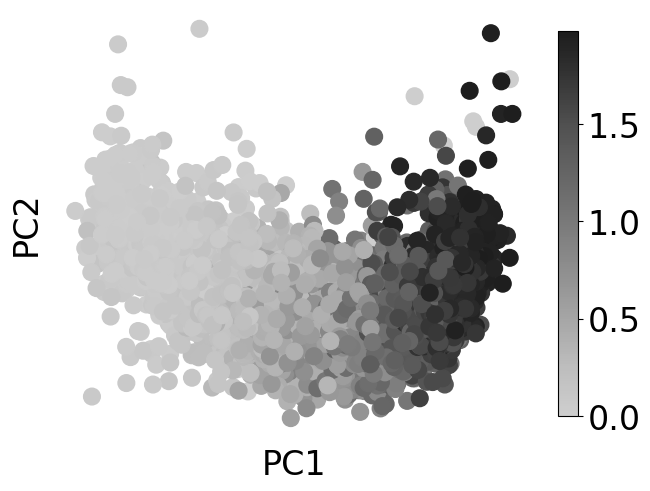

In [180]:
print(traj.elbos[-1])
t_hat = traj.Q.sum(1)@traj.t
cmap_y = cmr.get_sub_cmap('Greys', 0.3, 0.9)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

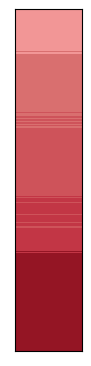

In [181]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i

fig, ax = plt.subplots(1,1,figsize=(0.8,3.55))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])
ax.set_yticks([])

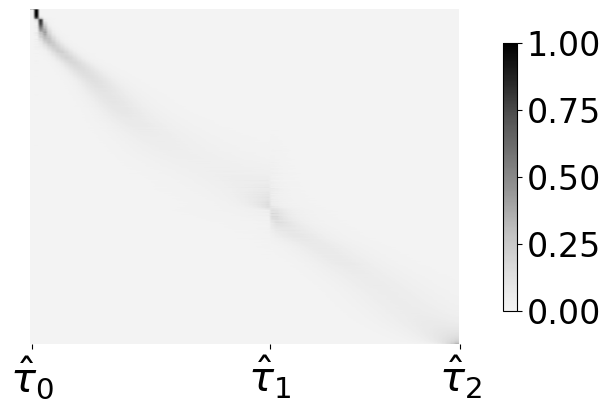

In [182]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
cmap_Q = cmr.get_sub_cmap('Greys', 0.1, 1)

im = ax.imshow(traj.Q.sum(1)[order],aspect="auto",cmap=cmap_Q);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = [r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

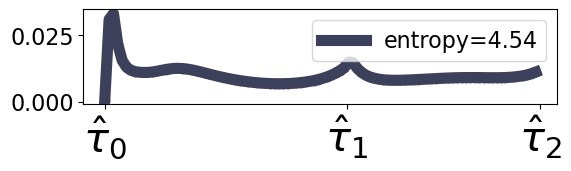

In [123]:
plt.rcParams['font.size'] = '16'
fig,ax = plt.subplots(figsize=(5.6,1.6))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8,\
        label="entropy="+str(np.around(entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)));
x_label_list = [r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
#ax.set_xticklabels(x_label_list)
#ax.set_xlabel('Process time',fontsize=24)
#ax.set_ylabel('Probability mass',fontsize=24)
ax.legend()
plt.rcParams['font.size'] = '24'

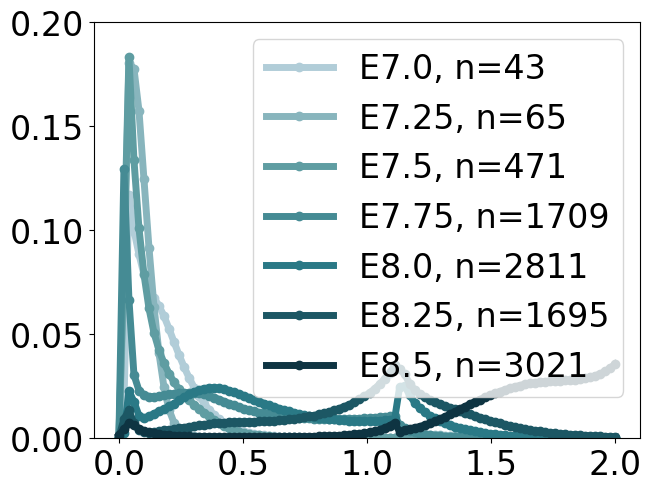

In [124]:
Timepoints = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']

color_palette = ["#b3cde0","#6497b1","#011f4b"]
color_palette = ["#b1cdd8","#5f9da2","#2a7986","#0e3442"]


timepoint_cmp = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Timepoints))

for i,timepoint in enumerate(Timepoints):
    idx = adata.obs["stage"].isin([timepoint])
    plt.plot(traj.t,traj.Q[idx,0].mean(0),'.-',linewidth=5,label=timepoint+", n="+str(idx.sum()),color=timepoint_cmp(i))
plt.ylim((0,0.2))
plt.legend(loc='upper right');

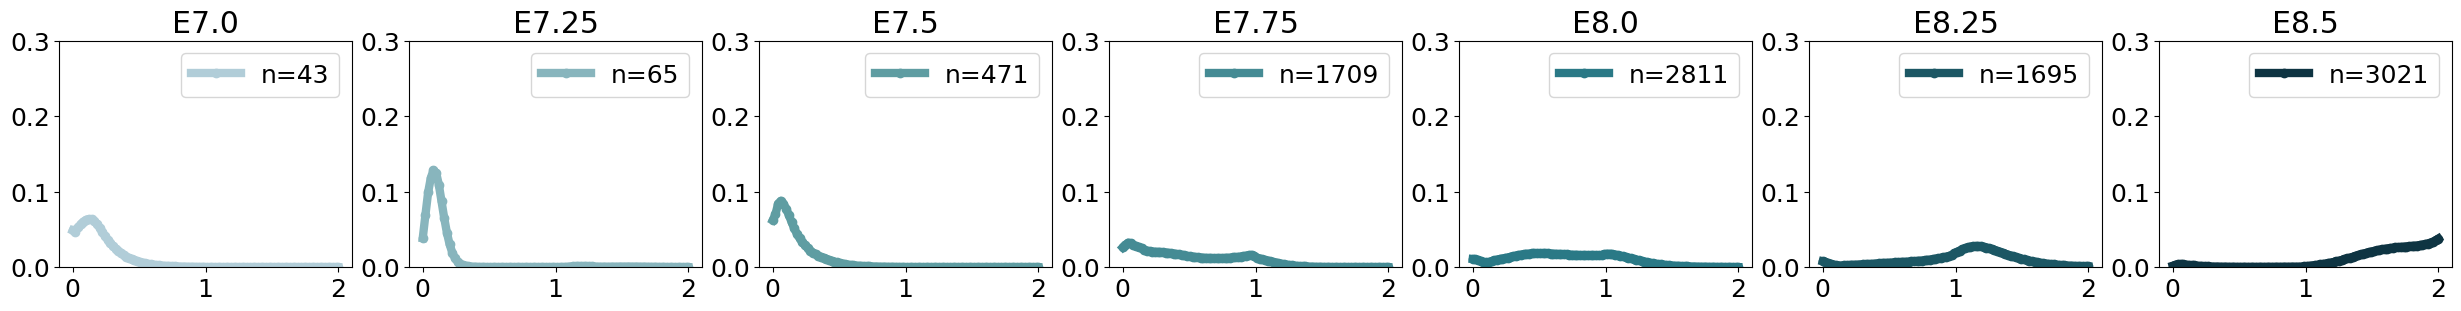

In [270]:
stages = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']
fig, ax = plt.subplots(1,len(stages),figsize=(3.5*len(stages),3))
for i,stage in enumerate(stages):
    idx = adata.obs["stage"].isin([stage])
    ax[i].plot(traj.t,traj.Q[idx,0].mean(0),'.-',label="n="+str(idx.sum()),color=timepoint_cmp(i))
    ax[i].set_title(stage)
    ax[i].set_ylim((0,0.3))
    ax[i].legend()

Text(0, 0.5, 'Explained variance')

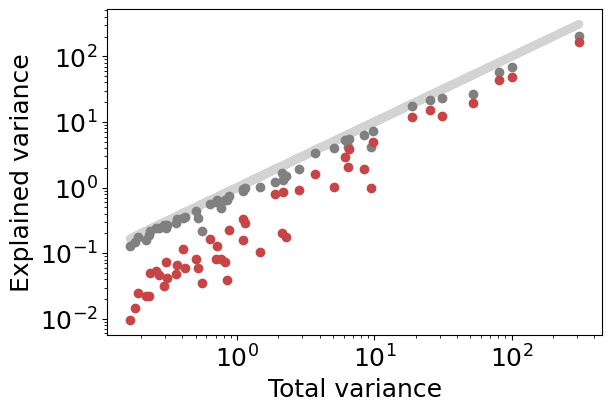

In [283]:
Y_grid = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)[0]
Y = traj.params['r'][:,None,None] * np.sum(traj.Q[:,:,:,None,None]* Y_grid[None,:],axis=(1,2)) 

mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,4))
plt.loglog(var,var,color='lightgray')
plt.loglog(var,Y_var+Y_mean,'.',color='gray')
plt.loglog(var,Y_var,'.',color='#c74546')
plt.xlabel('Total variance')
plt.ylabel('Explained variance')

array([ 0.9713918 ,  1.69953272,  0.532554  ,  4.11178453,  2.96615012,
        0.46764813,  0.54849575,  0.10645305,  0.22868507,  4.0854033 ,
        0.68969429,  0.48186358,  0.49496361,  0.10543572,  0.08033577,
        0.06869267, 10.32071601,  0.38372292,  0.51722918,  0.55658932,
        0.25697256,  1.59179191,  0.13721273,  0.42122487,  0.43492308,
        0.05027972,  0.46660289,  0.11154918,  0.8091388 ,  2.61302041,
        0.39462089,  0.28409647,  0.12164033,  2.1256816 ,  0.06242119,
        0.402676  ,  0.54571319,  1.35543815,  2.19396627,  0.33991935,
        0.41477638,  1.21383844,  0.50259303,  0.64612538,  0.45834449,
        0.11787161,  1.24076763,  0.71017089,  0.42123322])

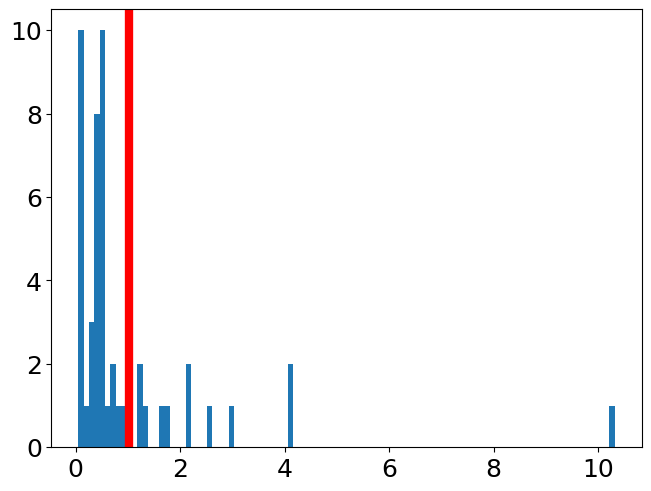

In [290]:
phi = (var-(Y_var+Y_mean))/mean**2
plt.hist(phi,bins=100);
plt.axvline(phi.mean(),color='r');
phi

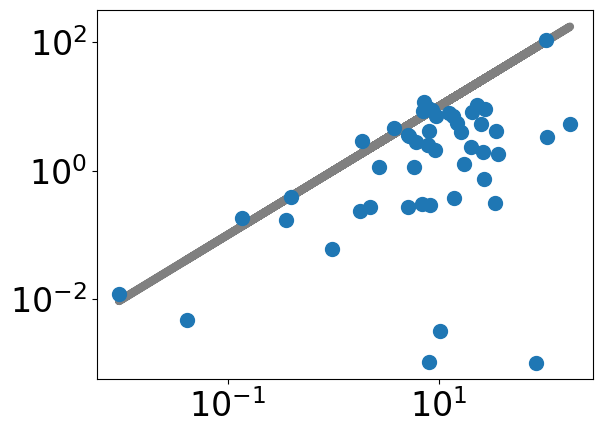

In [59]:
plt.loglog(traj.theta[:,[-2]],traj.theta[:,[-2]],'-',color='gray');
plt.loglog(traj.theta[:,[-2]],traj.theta[:,[-1]],'.');

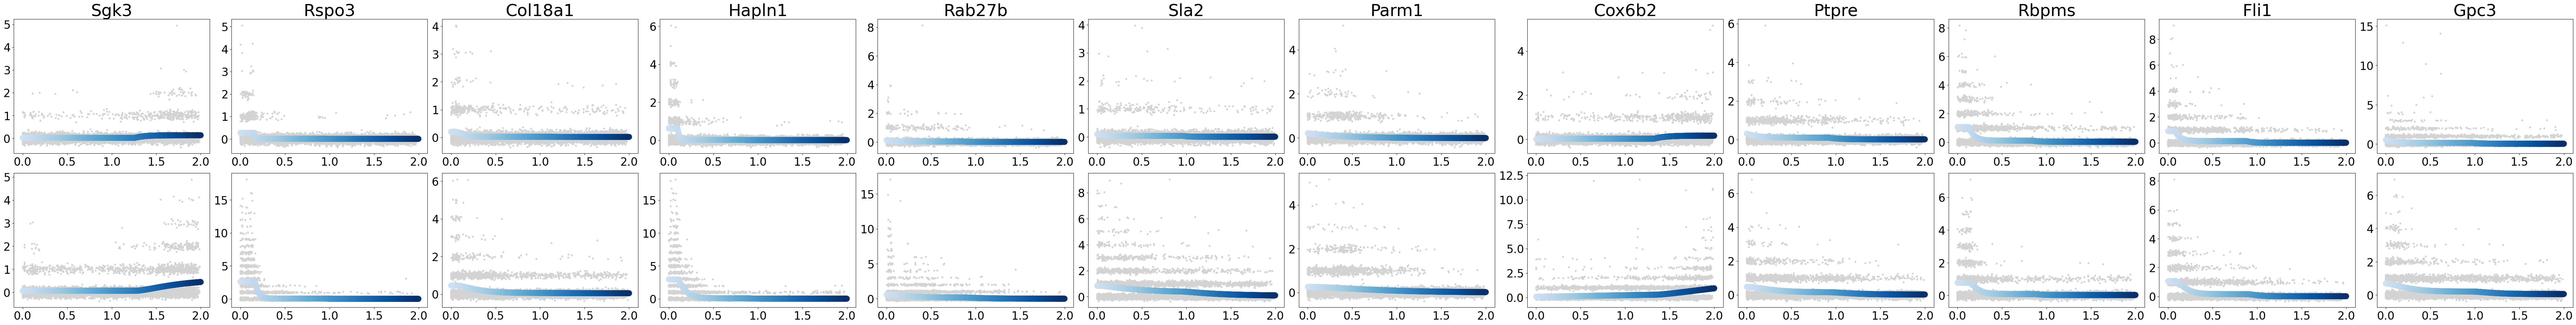

In [393]:
plot_y(traj,X=X,idx=np.where(phi>1)[0],gene_name=fitted_genes);

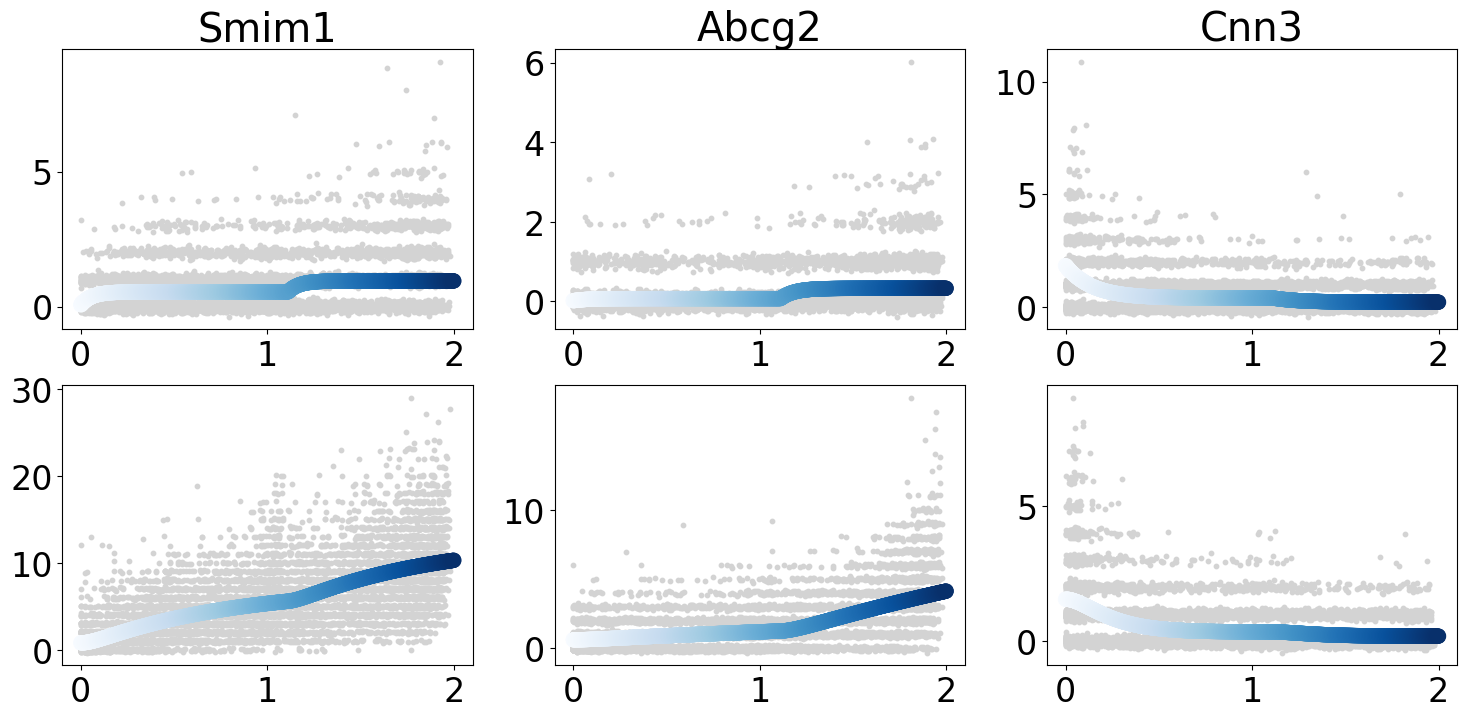

In [66]:
plot_y(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

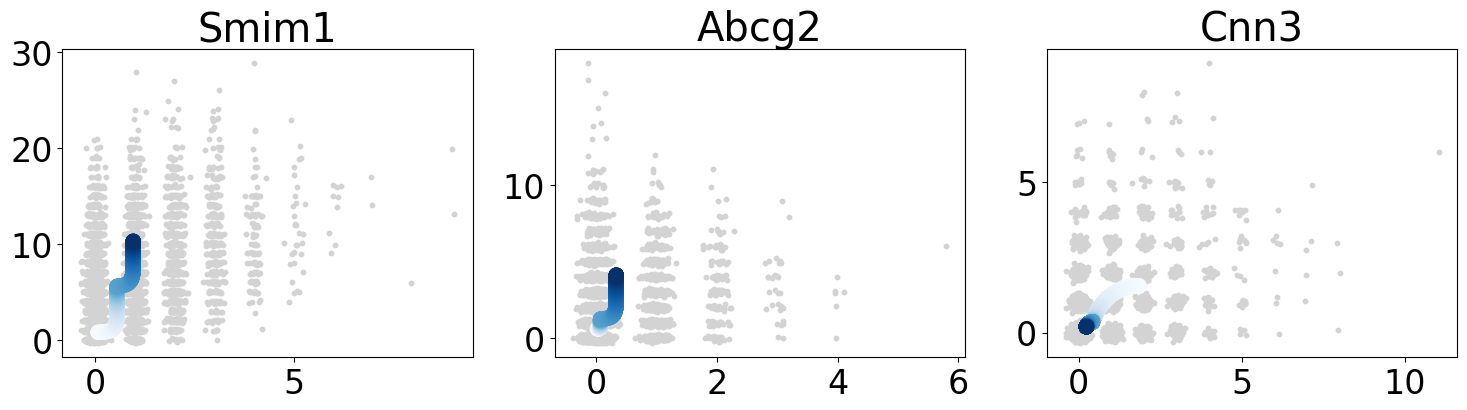

In [67]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

In [69]:
marker_genes = ['Gata1','Gata2','Hba-x']

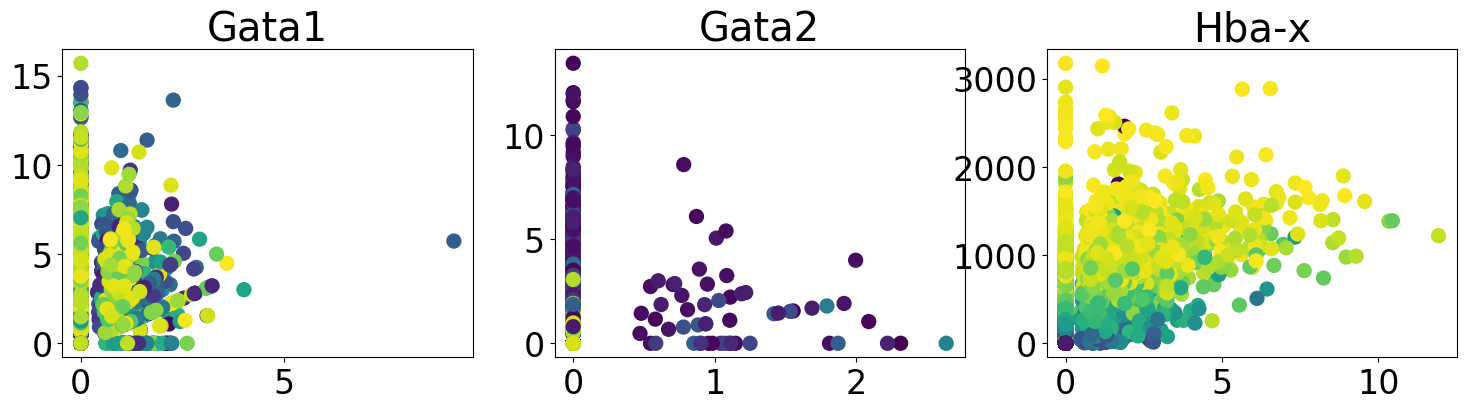

In [70]:
fig,ax = plt.subplots(1,len(marker_genes),figsize=(6*len(marker_genes),4))
for i,gene in enumerate(marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

In [59]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

In [192]:
p = len(gene_logL)
dlogL = gene_logL - cluster_gene_logL
dH = (cluster_KL-KL)/p

good_mask = (dlogL>dH) \
            & (traj.theta[:,-2]<500)  \
            & (traj.theta[:,-1]<100)
good_idx = np.arange(p)[good_mask]
print(good_mask.mean())
len(good_idx)

0.42857142857142855


21

## Random initializations

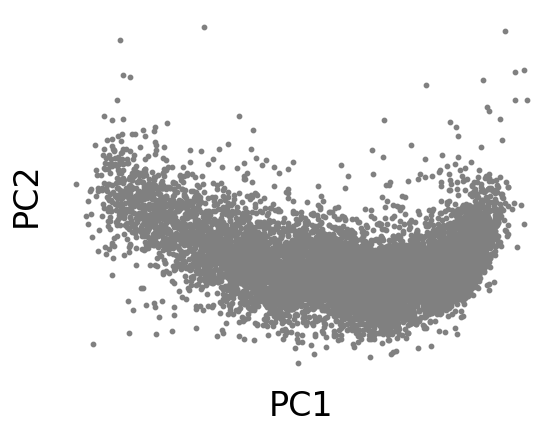

In [74]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [135]:
from multiprocessing import Pool

tau = (0,1,2)
topo = np.array([[0,1,2]])
params={'r':rd,"lambda_tau":0,"lambda_a":0}

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [402]:
corrs = []
AICs = []
right_t = Q0[:,0] @ trajs[0].t
for traj in trajs:
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(pearsonr(right_t,t_hat)[0])
    AICs.append( traj.compute_AIC(traj.X, standard=True) )

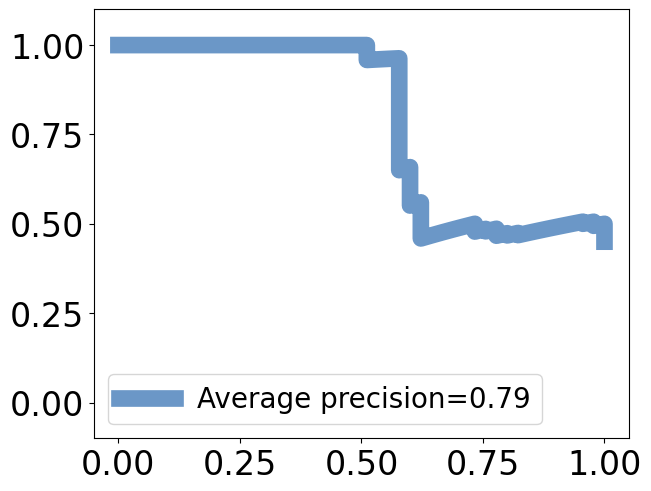

In [403]:
from sklearn.metrics import average_precision_score, precision_recall_curve

is_correct_direction = np.array(np.array(corrs)>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)
precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=-np.array(AICs))
score = average_precision_score(y_true=is_correct_direction, y_score=-np.array(AICs))
plt.plot(recall, precision,'-',color='#3975b5',alpha=0.75,label="Average precision="+str(np.around(score,2)))
plt.ylim([-0.1,1.1])
plt.legend(fontsize=20)

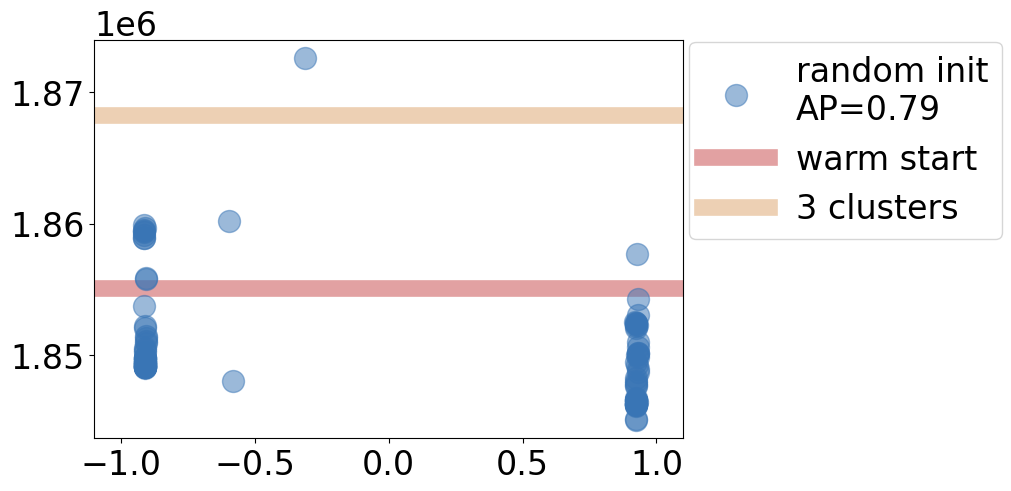

In [404]:
fig, ax = plt.subplots(1,1,figsize=(10,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='random init\nAP='+str(np.around(score,2)))
plt.axhline(traj_ws.compute_AIC(traj.X, standard=True),linewidth=12,zorder=0,color='#c74546',alpha=0.5,label='warm start')
plt.axhline(PM.compute_AIC(traj.X, standard=True),color='#dca36a',linewidth=12,zorder=0,alpha=0.5,label='3 clusters')
#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
plt.legend(loc=(1.01,0.5),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

In [343]:
traj = trajs[np.argmin(AICs)]
print(traj.elbos[0][-1],traj.compute_AIC(X,standard=False),traj.compute_BIC(X,standard=False))

-93.96771159951356 -93.99267339268728 -94.08243184613323


In [344]:
theta0 = np.zeros((p,traj.n_states+traj.K+2))
theta0[:,:traj.n_states] = traj.theta[:,:traj.n_states]
theta0[:,-2:] = traj.theta[:,-2:]
theta0[:,traj.n_states:-2] = traj.tau[None,:-1]

traj_ri_tau = Trajectory(traj.topo, traj.tau, model="two_species_ss_tau",verbose=1)
traj_ri_tau = traj_ri_tau.fit(X,warm_start=True,theta=theta0,params={"r":rd,"lambda_tau":0.01,"bnd_tau":1},fit_tau=False,norm_Q=True,parallel=True,n_threads=10,epoch=100)
print(traj_ri_tau.compute_AIC(X,standard=False))

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 100/100 [04:22<00:00,  2.62s/it]

-93.60233656355838


In [347]:
data["ri_tau"] = copy.deepcopy(traj_ri_tau)
with open('results/Erythoid.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [370]:
traj = copy.deepcopy(data['ri_tau'])
traj.params["lambda_tau"]=0
traj.model, traj.topo, traj.tau, traj.params.keys(), traj.compute_AIC(X,standard=False)

('two_species_ss_tau',
 array([[0, 1, 2]]),
 array([0.        , 1.13131395, 2.        ]),
 dict_keys(['r', 'lambda_tau', 'bnd_tau', 'lambda_a', 'fit_tau']),
 -93.57093127177934)

[0.         1.13131395 2.        ]


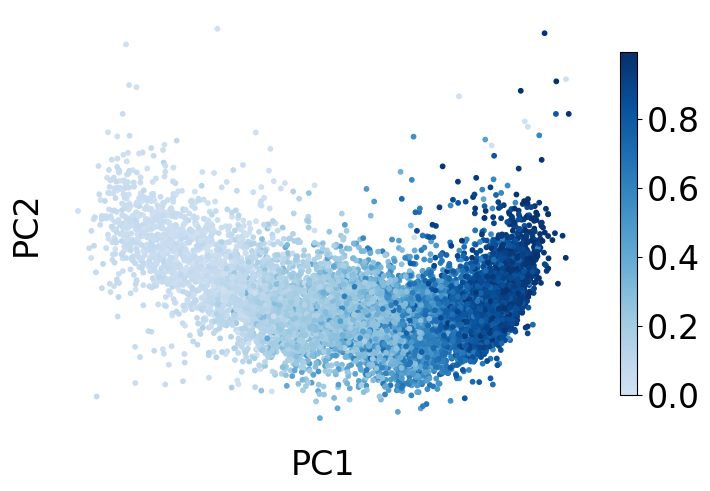

In [371]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1,figsize=(7,4.8))
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t/2,cmap=cmap_y,s=10);
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink = 0.8) # adding the colobar on the right
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)

[]

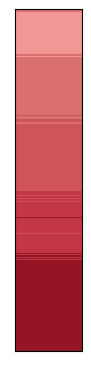

In [372]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i

fig, ax = plt.subplots(1,1,figsize=(0.8,3.55))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])
ax.set_yticks([])

[]

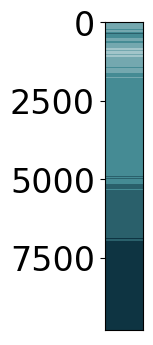

In [373]:
Timepoints = Stages
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,timepoint in enumerate(Timepoints):
    idx = adata.obs["stage"].isin([timepoint])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_teal)
ax.set_xticks([])

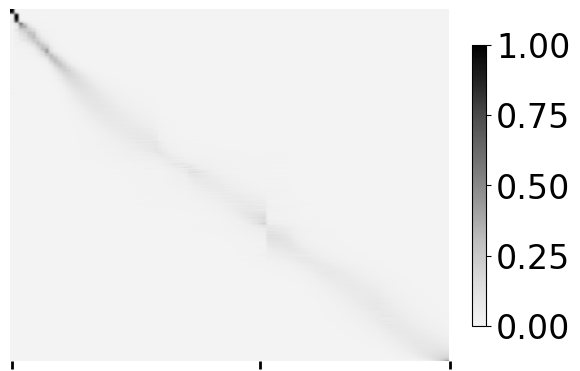

In [374]:
fig, ax = plt.subplots(1,1,figsize=(5.7,3.6))
cmap_Q = cmr.get_sub_cmap('Greys', 0.1, 1)

im = ax.imshow(traj.Q.sum(1)[order],aspect="auto",cmap=cmap_Q);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = []#[r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

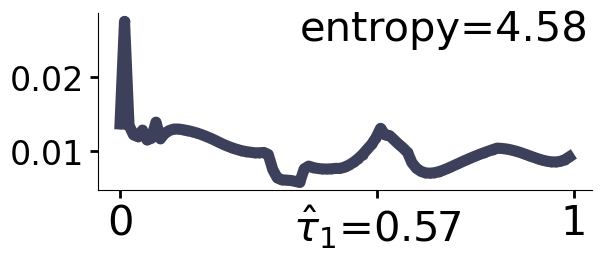

In [375]:
fig,ax = plt.subplots(figsize=(5.9,2.5))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8);
x_label_list = ['0', r'$\hat{\tau}_1$='+str(np.around(traj.tau[1]/traj.tau[-1],2)), '1']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.text(40,0.025,"entropy="+str(np.around(entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)),fontsize=label_font)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

Text(0, 0.5, 'Probabilty mass')

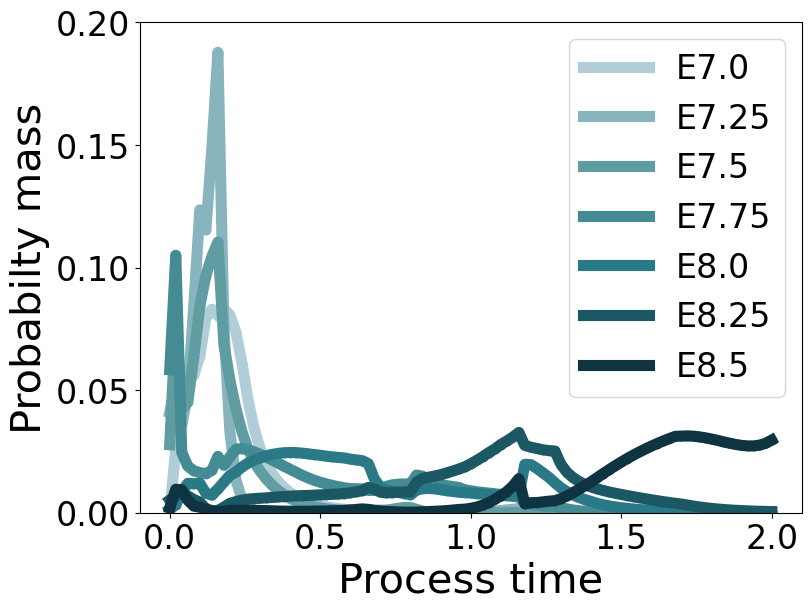

In [376]:
Timepoints = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']

#color_palette_blue = ["#b3cde0","#6497b1","#005b96","#011f4b"]
#color_palette = ["#daf8e3","#97ebdb","#00c2c7","#0086ad","#005582"]
#color_palette = ["#006666","#008080","#66b2b2","#b2d8d8"]
color_palette = ["#b1cdd8","#5f9da2","#2a7986","#0e3442"]

from matplotlib.colors import LinearSegmentedColormap
timepoint_cmp = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Timepoints))

plt.figure(figsize=(8,6))
for i,timepoint in enumerate(Timepoints):
    idx = adata.obs["stage"].isin([timepoint])
    plt.plot(traj.t,traj.Q[idx,0].mean(0),'.-',linewidth=8,color=timepoint_cmp(i),label=timepoint)#+", n="+str(idx.sum()))
plt.ylim((0,0.2))
plt.legend(fontsize=24);
plt.xlabel('Process time',fontsize=30)
plt.ylabel('Probabilty mass',fontsize=30)
#plt.title('Posterior distribution',fontsize=32)

0.19
0.15
0.16
0.43
0.65
0.99
1.57


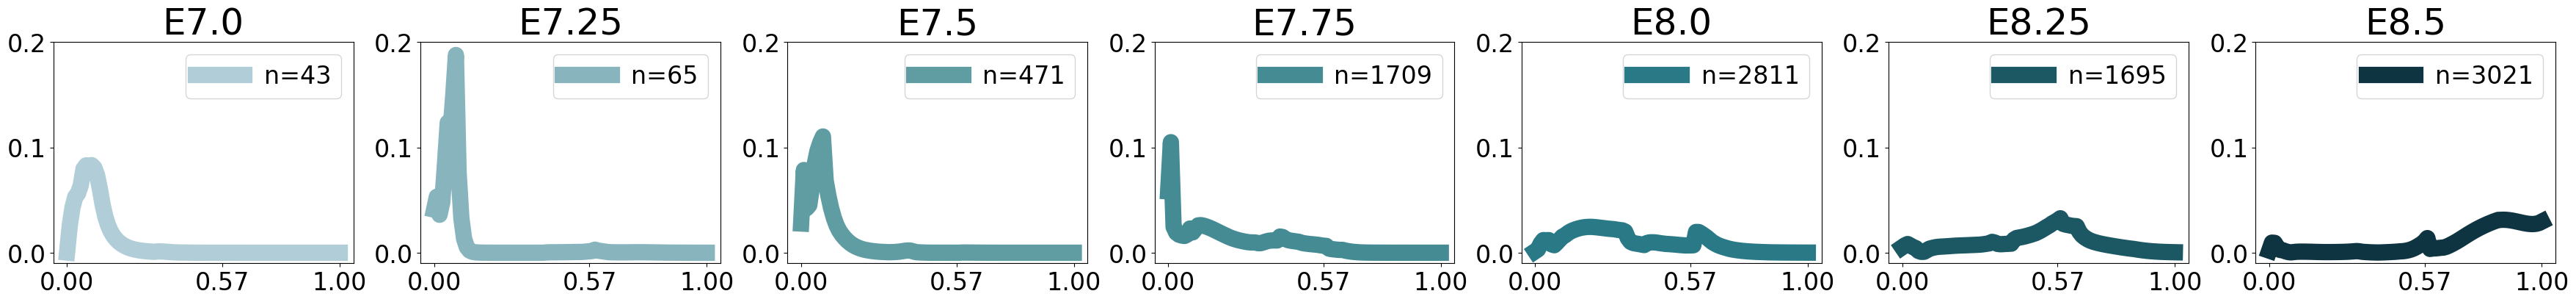

In [377]:
stages = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']
fig, ax = plt.subplots(1,len(stages),figsize=(5*len(stages),4))
for i,stage in enumerate(stages):
    idx = adata.obs["stage"].isin([stage])
    ax[i].plot(traj.t/traj.tau[-1],traj.Q[idx,0].mean(0),'.-',linewidth=16,label="n="+str(idx.sum()),color=timepoint_cmp(i))
    ax[i].set_title(stage,fontsize=title_font)
    ax[i].set_ylim((-0.01,0.2))
    ax[i].set_xticks(np.around(traj.tau/traj.tau[-1],2))
    ax[i].legend(fontsize=legend_font)
    print(np.around(traj.Q[idx,0].mean(0)@traj.t,2))

### Remaining noise

Text(0, 0.5, 'Explained percentage')

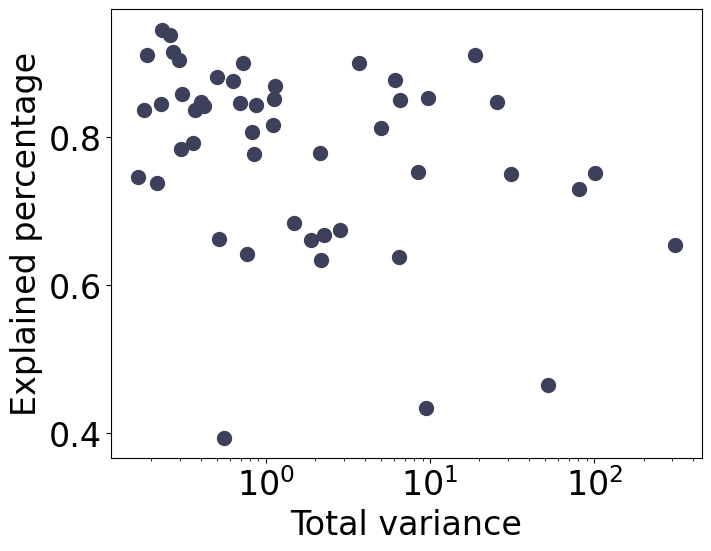

In [378]:
Y_grid = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)[0]
Y = traj.params['r'][:,None,None] * np.sum(traj.Q[:,:,:,None,None]* Y_grid[None,:],axis=(1,2)) 

mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)

fig, ax = plt.subplots(figsize=(7,5.4))
plt.scatter(var,(Y_var+Y_mean)/var,color='#3d405b',s=100)
plt.xscale('log')
plt.xlabel('Total variance',fontsize=24)
plt.ylabel('Explained percentage',fontsize=24)

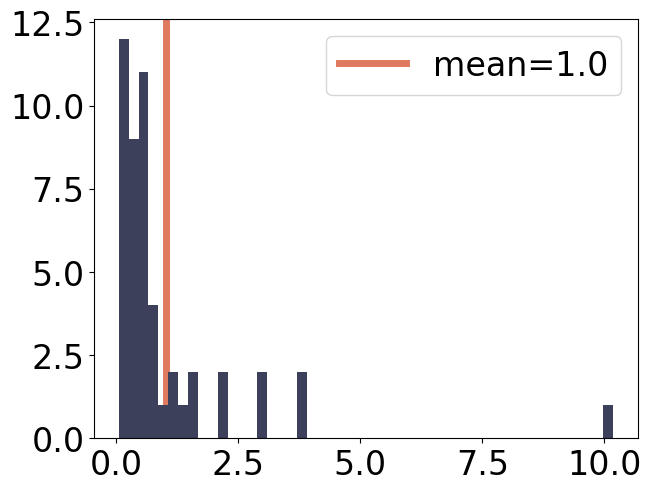

In [379]:
phi=(var-Y_var-Y_mean)/mean**2
plt.hist(phi,bins=50,color='#3d405b');
plt.axvline(x=phi.mean(),color='#e07a5f',label='mean='+str(np.around(phi.mean(),1)),linewidth=5,zorder=0);
plt.legend()

### Gene selection

In [360]:
cluster_gene_logL, cluster_KL = PM.compute_gene_logL(traj.X,Q)
cluster_KL 

-0.9916697032724092

In [380]:
gene_logL, KL = traj.compute_gene_logL(traj.X,traj.Q)

In [381]:
p = len(gene_logL)
dlogL = gene_logL - cluster_gene_logL
dH = (cluster_KL-KL)/p

good_mask = (dlogL>dH) \
            & (traj.theta[:,-2]<500)  \
            & (traj.theta[:,-1]<100)
good_idx = np.arange(p)[good_mask]
print(good_mask.mean())
len(good_idx)

0.4489795918367347


22

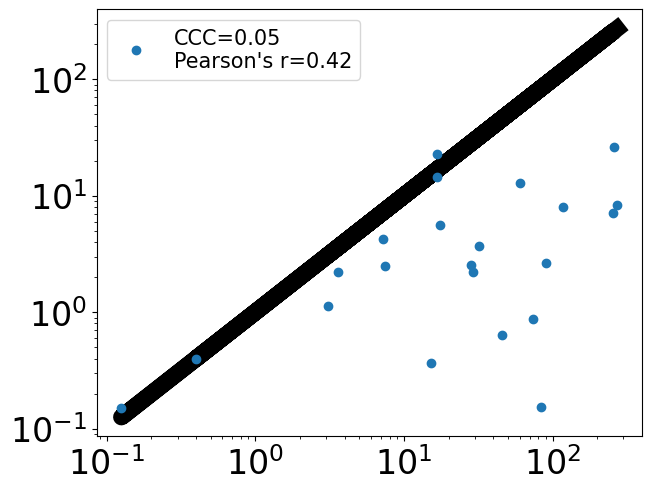

In [382]:
plot_cor(traj.theta[good_idx,-2],traj.theta[good_idx,-1])

46.16323231876588 11.670309156522096


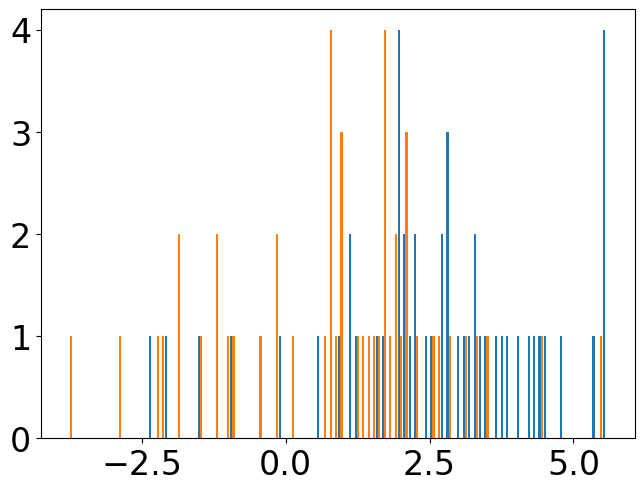

In [383]:
plt.hist([np.log(traj.theta[:,-2]),np.log(traj.theta[:,-1])],bins=100)
print(traj.theta[:,-2].mean(),traj.theta[:,-1].mean())

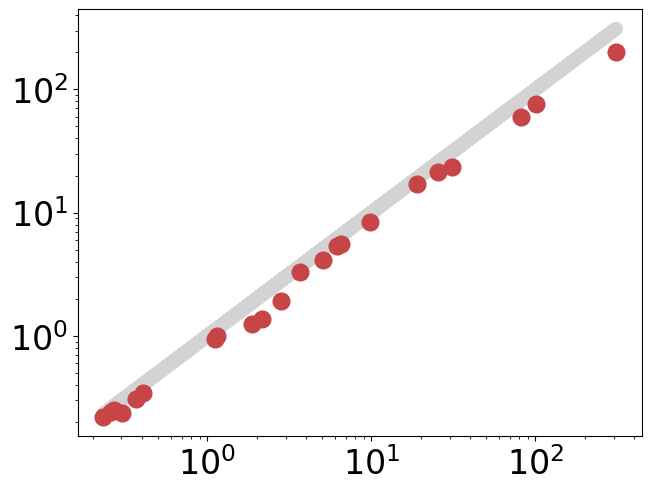

In [384]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))
plt.loglog(var[good_idx],var[good_idx],color='lightgray',linewidth=10,zorder=0)
plt.scatter(var[good_idx],Y_var[good_idx]+Y_mean[good_idx],color='#c74546')

### DE genes

In [385]:
alpha = traj.theta[good_idx,:3]
DE_mask = (np.max(alpha,axis=1)/(np.min(alpha,axis=1))>14) & (np.min(alpha,axis=1)>0.01)
DE_idx = np.arange(p)[good_idx][DE_mask]
DE_idx

array([ 6, 13, 32, 38, 41, 44])

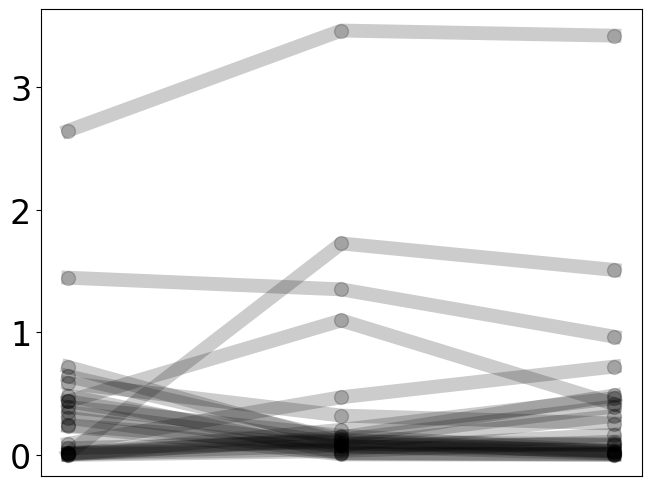

In [386]:
fig,ax = plt.subplots(1,1)
for j in good_idx:
    ax.plot(np.log1p(traj.theta[j,[0,1,2]]),'.-',linewidth=10,markersize=20,color='k',alpha=0.2)
#for j in DE_idx:
#    ax.plot(np.log1p(traj.theta[j,[0,1,2]]),'-',color='#e0a295',alpha=0.5)

ax.set_xticks([]);
#x_label_list = ['α0', 'α1', 'α2']
#ax.set_xticklabels(x_label_list)

In [387]:
fitted_genes[DE_idx]

Index(['Slc25a21', 'Cpox', 'Abcg2', 'Rbpms', 'Fli1', 'Prtg'], dtype='object', name='index')

In [300]:
def plot_phase(traj,X=None,idx=np.arange(10),l=0,gene_name=None,cell_colors=None):
    if X is None:
        X = traj.X
    weight = traj.Q
    theta_hat = traj.theta.copy()
    tau=traj.tau
    n,L,m=np.shape(weight)
    p=np.shape(traj.theta)[0]
    #t_hat=np.sum(weight[:,:,:]*traj.t[None,None,:],axis=(1,2))
    t = np.linspace(tau[0], tau[-1],1001)
    if gene_name is None:
        gene_name = np.arange(p)
    if cell_colors is None:
        cell_colors = 'lightgrey'
      
    fig, ax = plt.subplots(1,len(idx),figsize=(5*len(idx),4),constrained_layout=True)
    if len(idx)==1:
        i=idx[0]
        ax.scatter(X[:,i,0]+np.random.normal(0,0.1,n),X[:,i,1]+np.random.normal(0,0.1,n),c=cell_colors,s=10);
        ax.set_title(gene_name[i],fontsize=title_font)
    else:
        for i,j in enumerate(idx):
            ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,n),X[:,j,1]+np.random.normal(0,0.1,n),c=cell_colors,s=10);
            ax[i].set_title(gene_name[j],fontsize=title_font)
        
    Y_hat = traj.get_Y_hat(theta_hat,t,tau,traj.topo,traj.params) #(L,len(t),p,2)                                                                                                                            
    if 'r' in traj.params:
        y_hat = Y_hat[l]*traj.params['r'].mean()
    else:
        y_hat = Y_hat[l]
        
    if len(idx)==1:
        i=idx[0]
        ax.scatter(y_hat[:,i,0],y_hat[:,i,1],c=t,cmap=cmap_ts[l]);
        
    else:
        for i,j in enumerate(idx):
            ax[i].scatter(y_hat[:,j,0],y_hat[:,j,1],c=t,cmap=cmap_ts[l]);
    return fig, ax

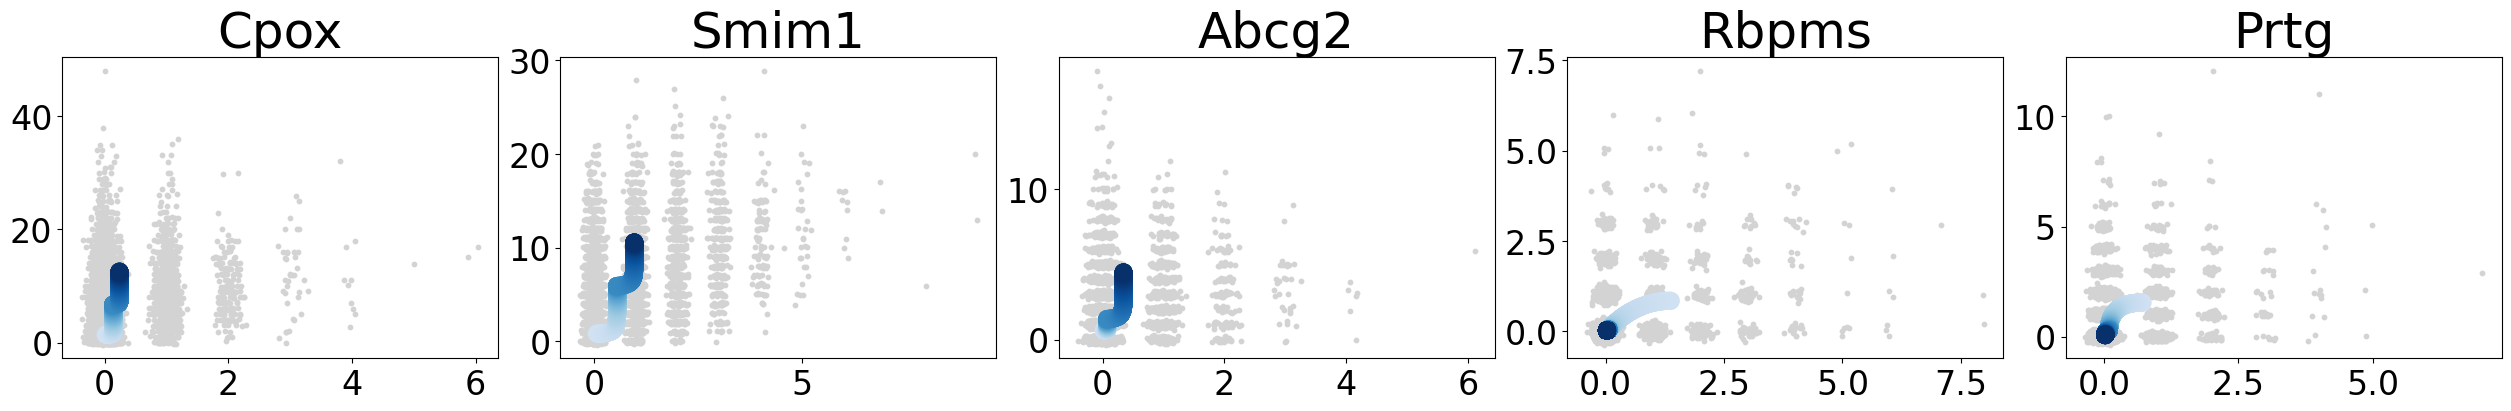

In [301]:
plot_phase(traj,idx=DE_idx,gene_name=fitted_genes);#,cell_colors=cell_colors

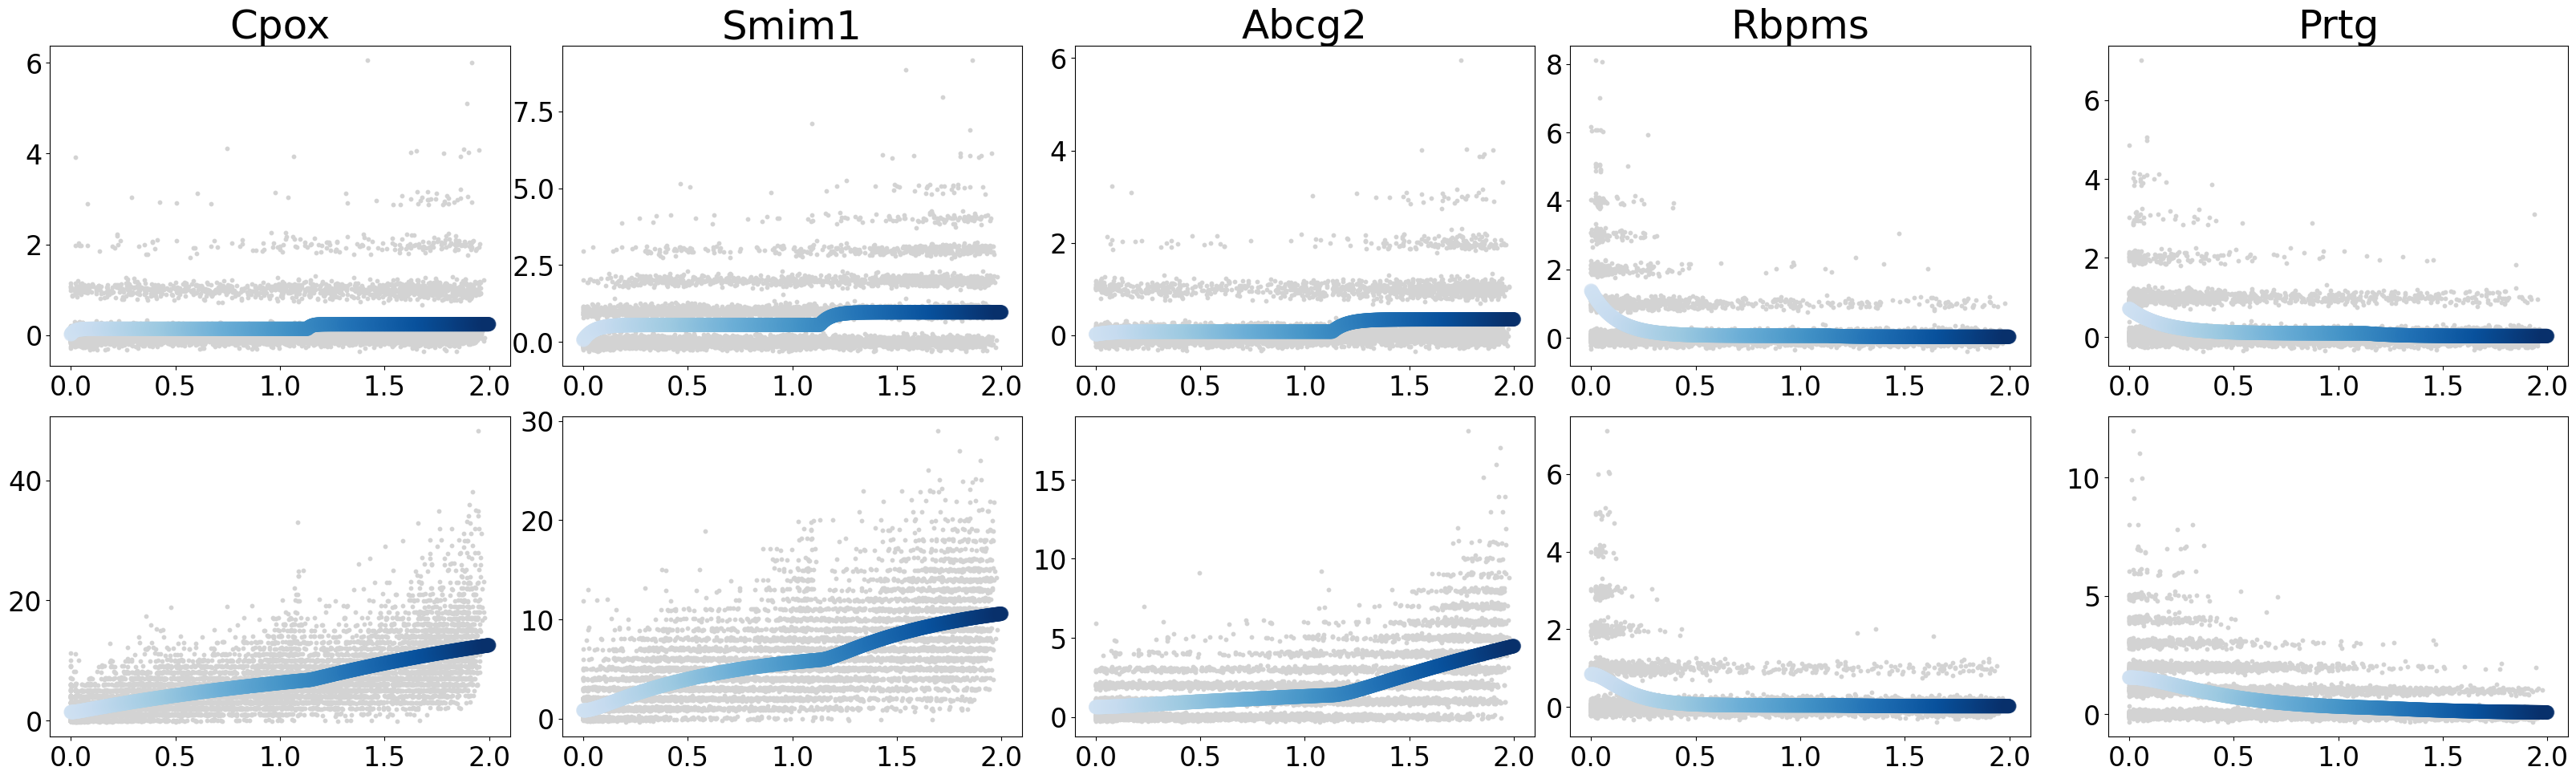

In [317]:
plot_y(traj,idx=DE_idx,gene_name=fitted_genes);

In [64]:
def plot_phase(traj,X=None,idx=np.arange(10),l=0,gene_name=None,cell_colors=None):
    if X is None:
        X = traj.X
    weight = traj.Q
    theta_hat = traj.theta.copy()
    tau=traj.tau
    n,L,m=np.shape(weight)
    p=np.shape(traj.theta)[0]
    #t_hat=np.sum(weight[:,:,:]*traj.t[None,None,:],axis=(1,2))
    t = np.linspace(tau[0], tau[-1],1001)
    if gene_name is None:
        gene_name = np.arange(p)
    if cell_colors is None:
        cell_colors = 'lightgrey'
      
    fig, ax = plt.subplots(1,len(idx),figsize=(6.4*len(idx),4.8),constrained_layout=True)
    if len(idx)==1:
        i=idx[0]
        ax.scatter(X[:,i,0]+np.random.normal(0,0.1,n),X[:,i,1]+np.random.normal(0,0.1,n),c=cell_colors,s=10,alpha=0.2);
        ax.set_title(gene_name[i],fontsize=title_font)
    else:
        for i,j in enumerate(idx):
            ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,n),X[:,j,1]+np.random.normal(0,0.1,n),c=cell_colors,s=10,alpha=0.2);
            ax[i].set_title(gene_name[j],fontsize=title_font)
        
    Y_hat = traj.get_Y_hat(theta_hat,t,tau,traj.topo,traj.params) #(L,len(t),p,2)                                                                                                                            
    if 'r' in traj.params:
        y_hat = Y_hat[l]*traj.params['r'].mean()
    else:
        y_hat = Y_hat[l]
        
    if len(idx)==1:
        i=idx[0]
        ax.scatter(y_hat[:,i,0],y_hat[:,i,1],c=t,cmap=cmap_ts[l]);
        
    else:
        for i,j in enumerate(idx):
            ax[i].scatter(y_hat[:,j,0],y_hat[:,j,1],c=t,cmap=cmap_ts[l]);
    return fig, ax

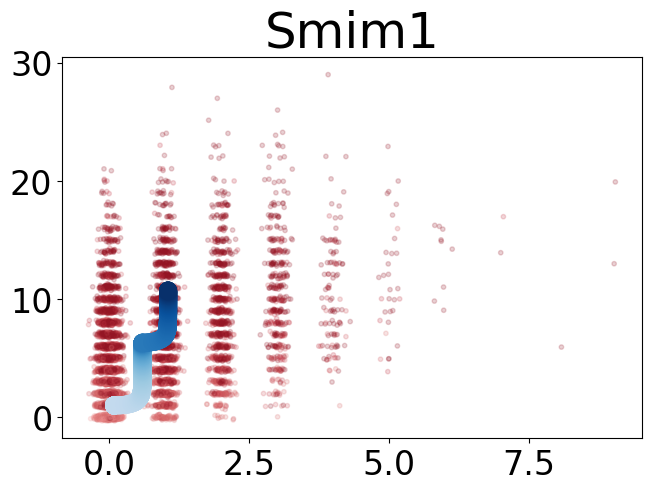

In [69]:
plot_phase(traj,idx=plot_idx[[0]],gene_name=fitted_genes,cell_colors=cell_colors);

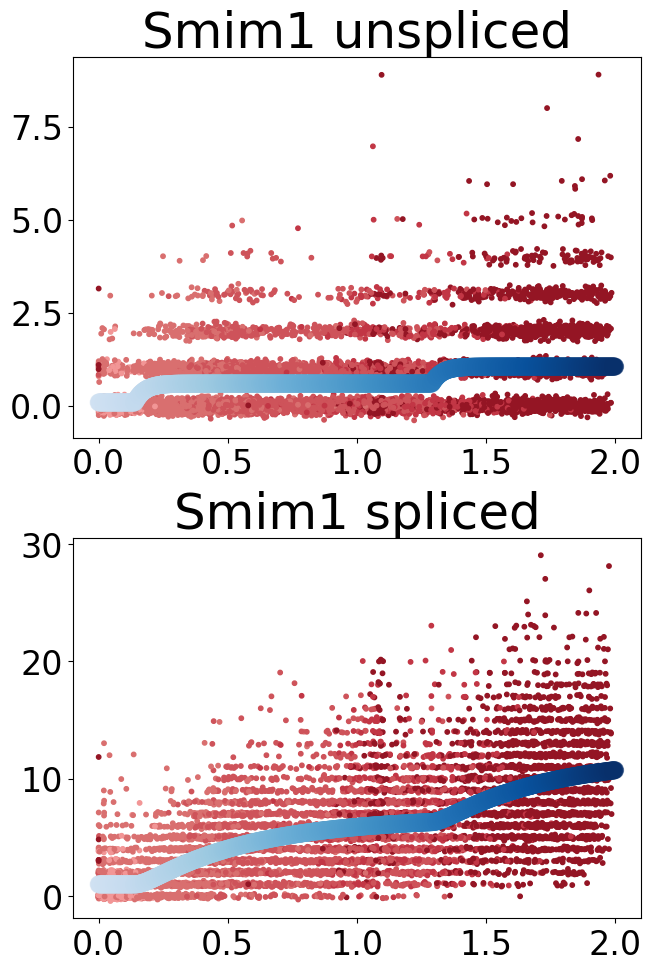

In [68]:
plot_y(traj,idx=plot_idx[[0]],gene_name=fitted_genes,cell_colors=cell_colors);

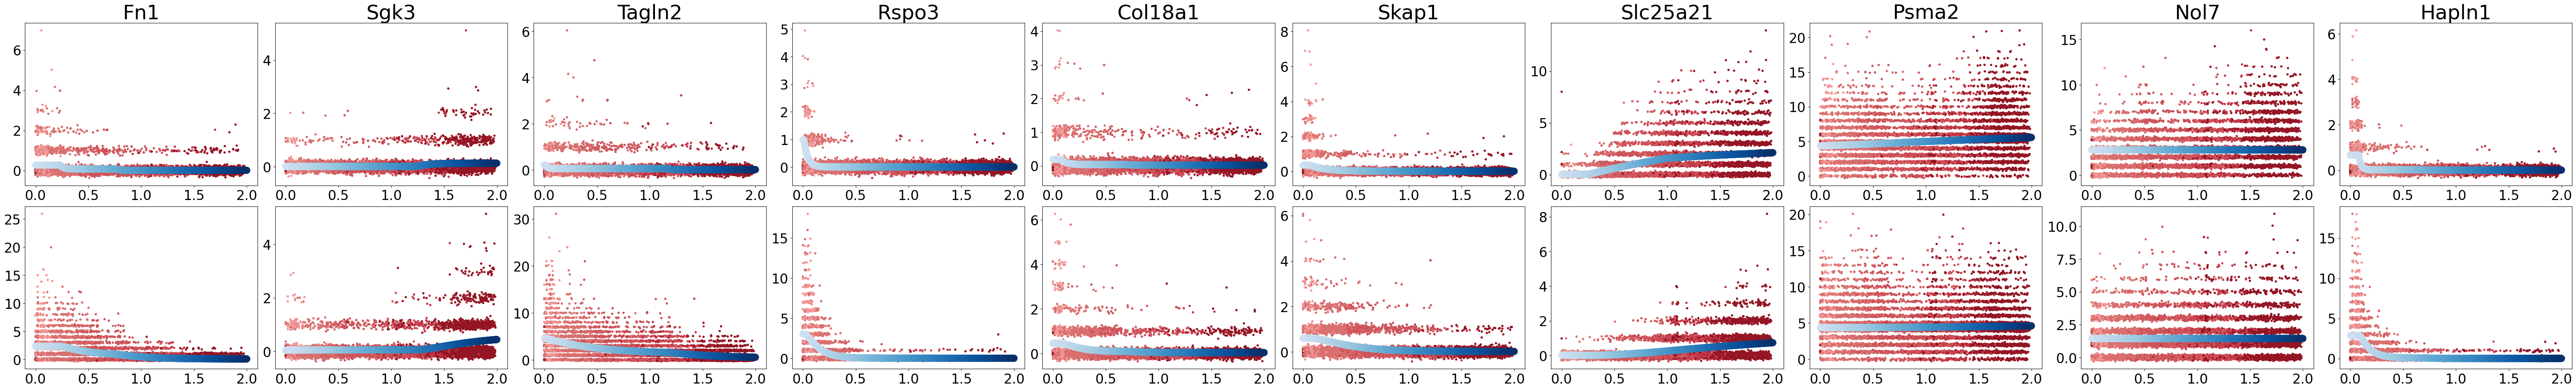

In [67]:
plot_y(traj,gene_name=fitted_genes,cell_colors=cell_colors);

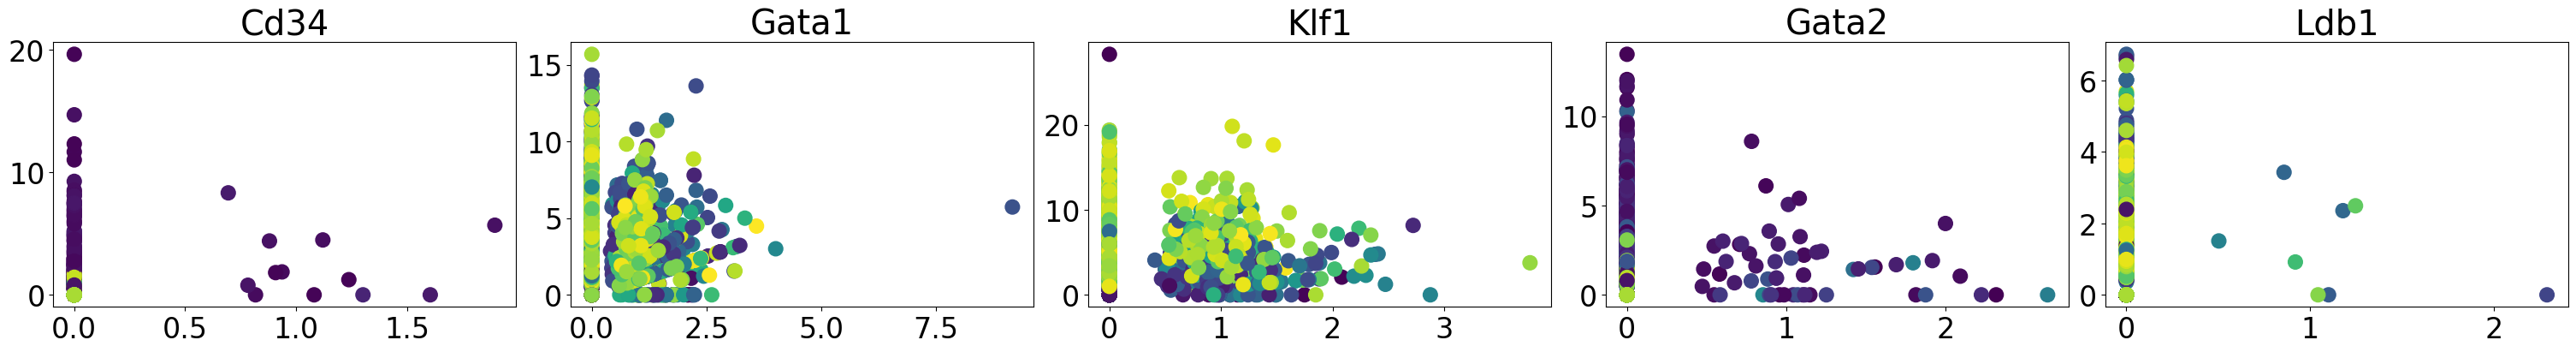

In [130]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

KeyboardInterrupt: 

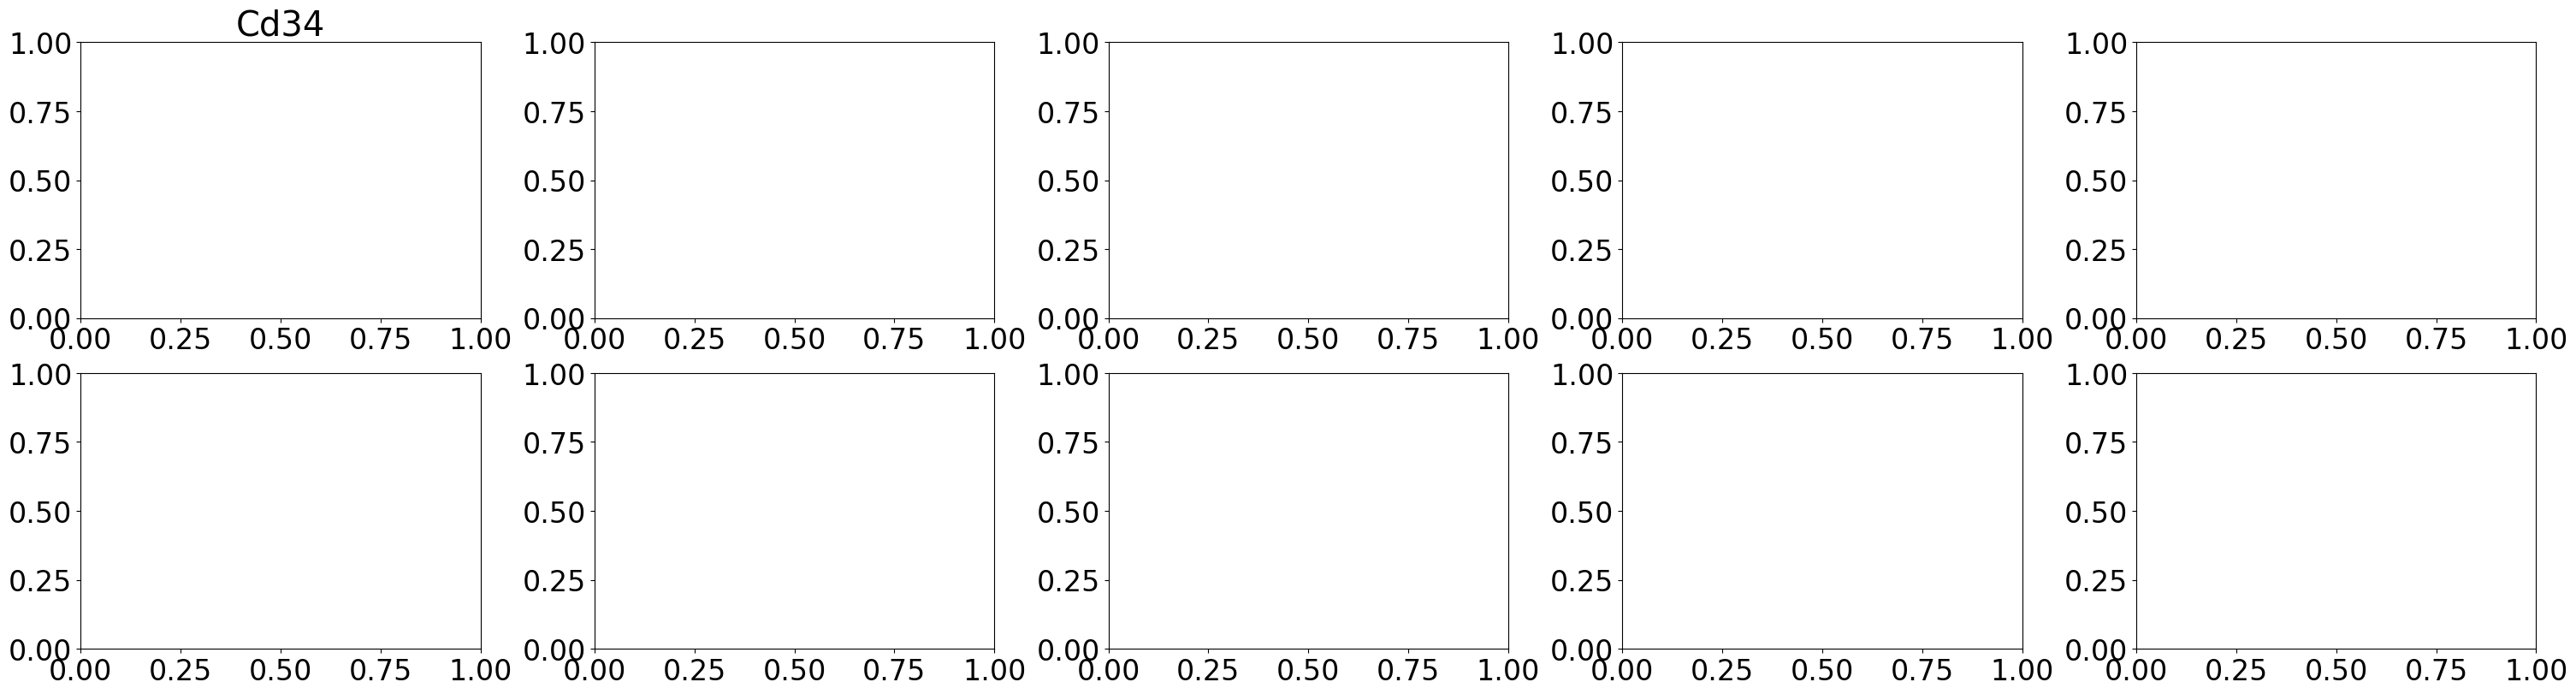

In [131]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

In [ ]:
plot_phase(traj,X=X,idx=DE_idx,gene_name=fitted_genes);

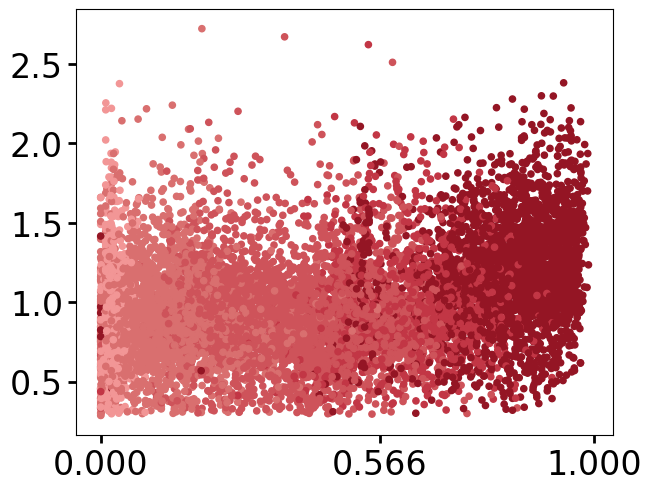

In [328]:
t_hat = (traj.Q.sum(1)@traj.t)/traj.tau[-1]

fig, ax = plt.subplots(1,1)
im=ax.scatter(t_hat,adata.X.toarray().mean(1)/adata.X.toarray().mean(),s=20,c=cell_colors);
x_label_list = ['0', str(np.around(traj.tau[1]/traj.tau[-1],2)),'1']
ax.tick_params(direction='out', length=6, width=2);
ax.set_xticks(traj.tau/traj.tau[-1]);

## Bootstrap

In [171]:
from sklearn.utils import resample

tau = (0,1,2)
topo = np.array([[0,1,2]])
n = len(X)

Input_args = []
def fit_wrapper(seed):
    bootstrap_idx = resample(np.arange(n),replace=True,n_samples=n,random_state=seed,stratify=clusters)
    X_b = X[bootstrap_idx]

    params_b={'r':rd[bootstrap_idx],"lambda_tau":0,"lambda_a":0}

    traj_b = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj_b = traj_b.fit(X_b,m=100,n_init=20,params=params_b,perm_theta=False,epoch=100,parallel=False,n_threads=1)
    return (bootstrap_idx,traj_b)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    bootstraps = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [397]:
bootstraps = data['bs']

In [398]:
corrs = []
AICs = []
original_t = traj.Q.sum(1) @ traj.t
original_t = Q0[:,0] @ trajs[0].t
for bootstrap_idx,traj_b in bootstraps:
    ref_t = original_t[bootstrap_idx]
    t_hat = traj_b.Q.sum(1) @ traj_b.t
    corrs.append(pearsonr(ref_t,t_hat)[0])
    #corrs.append(np.sqrt(np.mean((ref_t-t_hat)**2)))
    AICs.append( traj_b.compute_AIC(traj_b.X, standard=True) )

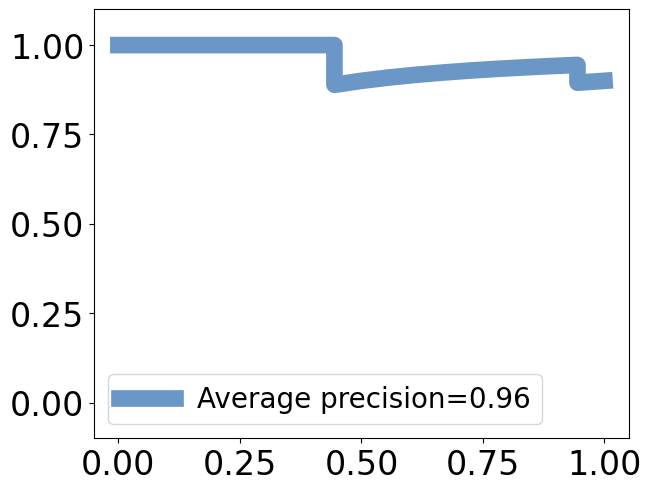

In [399]:
from sklearn.metrics import average_precision_score, precision_recall_curve

is_correct_direction = np.array(np.array(corrs)>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)
precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=-np.array(AICs))
score = average_precision_score(y_true=is_correct_direction, y_score=-np.array(AICs))
plt.plot(recall, precision,'-',color='#3975b5',alpha=0.75,label="Average precision="+str(np.around(score,2)))
plt.ylim([-0.1,1.1])
plt.legend(fontsize=20)

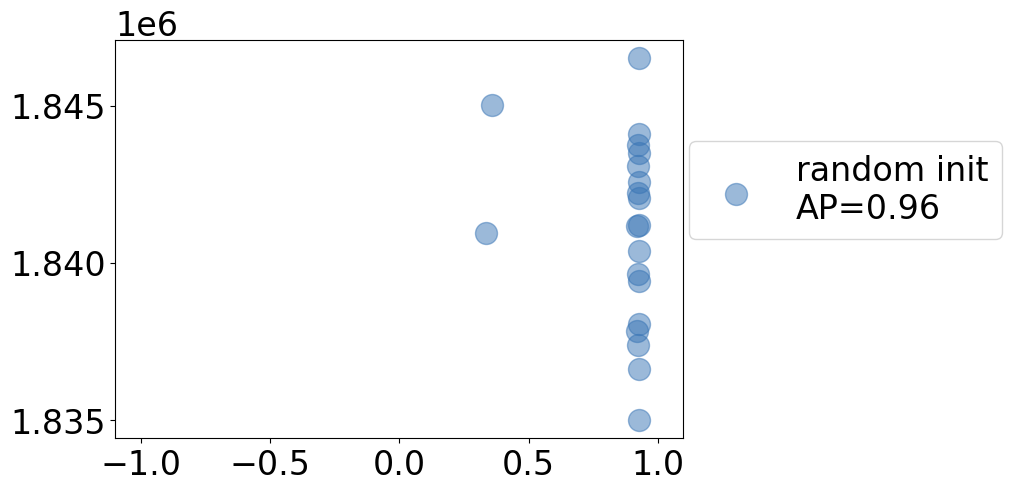

In [400]:
fig, ax = plt.subplots(1,1,figsize=(10,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='random init\nAP='+str(np.around(score,2)))
#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
plt.legend(loc=(1.01,0.5),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

**Not uniformally distributed**

In [176]:
corrs

[0.9215669556943777,
 0.9275631192820072,
 0.9272101447171628,
 0.9257708790189159,
 0.9268535772075109,
 0.9261479263379602,
 0.9244112175564637,
 0.9258757122295842,
 0.9243861912332177,
 0.9238221163560728,
 0.926370360376708,
 0.9266930225547394,
 0.9265885426470514,
 0.9269837819264882,
 0.926151709038762,
 0.9191209631904347,
 0.33393155251526596,
 0.3584134399844952,
 0.9282123605564684,
 0.9224320449843627]

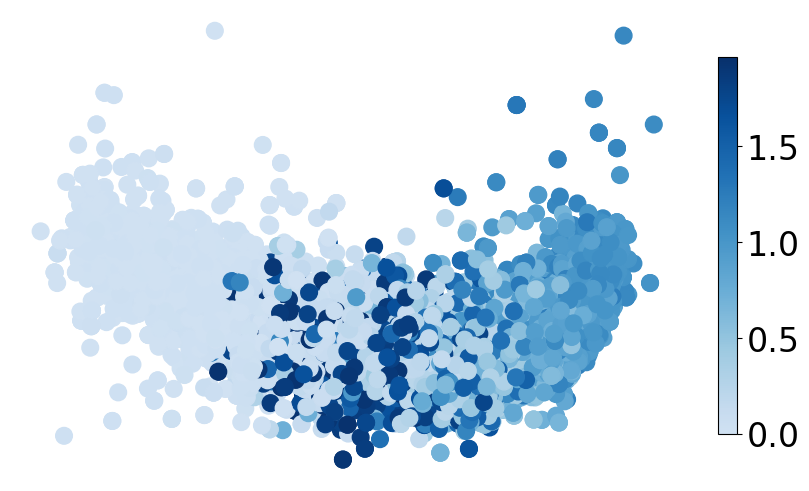

In [177]:
bootstrap_idx,traj_b = bootstraps[-3]
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
im=ax.scatter(x[bootstrap_idx,0],x[bootstrap_idx,1],c=traj_b.Q.sum(1)@traj_b.t,cmap=cmap_y);
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink = 0.8) # adding the colobar on the right

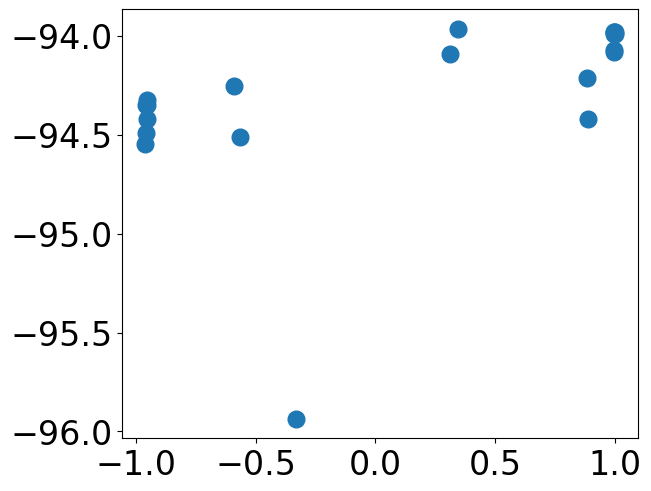

In [178]:
corrs = []
elbos = []

original_t = traj.Q.sum(1) @ trajs[0].t
ref_t = original_t[bootstrap_idx]
for i in range(len(traj_b.elbos)):
    t_hat = traj_b.Qs[i].sum(1) @ traj_b.t
    corrs.append(pearsonr(ref_t,t_hat)[0])
    elbos.append( traj_b.elbos[i][-1] )
plt.scatter(corrs,elbos)

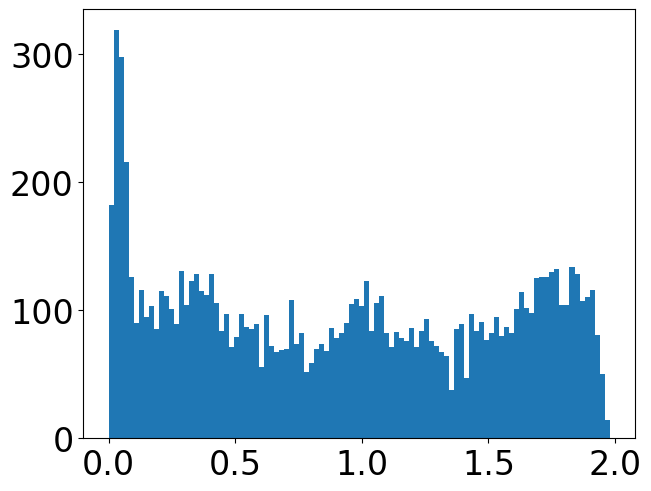

In [164]:
plt.hist(original_t[bootstrap_idx],bins=100);

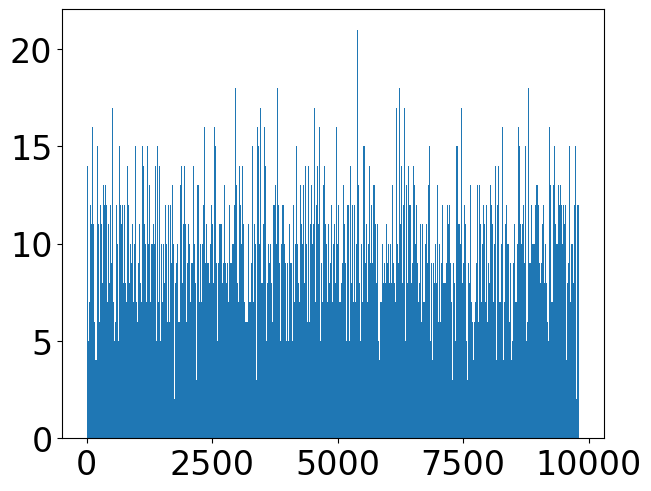

In [169]:
plt.hist(bootstrap_idx,bins=1001);

## Model selection

In [138]:
clusters

AAAGATCTCTCGAA    Blood progenitors 2
AATCTCACTGCTTT    Blood progenitors 2
AATGGCTGAAGATG    Blood progenitors 2
ACACATCTGTCAAC    Blood progenitors 2
ACGACAACTGGAGG    Blood progenitors 2
                         ...         
TTTCACGACTGGTA             Erythroid3
TTTCAGTGCGAGTT             Erythroid3
TTTCGAACGGTGAG             Erythroid3
TTTCGAACTAACCG             Erythroid3
TTTCTACTTCTCTA             Erythroid3
Name: celltype, Length: 9815, dtype: category
Categories (5, object): ['Blood progenitors 1', 'Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']

In [139]:
elbo_out = []
skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(skf.split(np.zeros(n), clusters)):
    X_train = X[train_index]
    X_test = X[test_index]
    r=rd[train_index]/rd[train_index].mean()
    PM = PoissonMixtureSS(n_components=3,verbose=0)
    Q, elbo = PM.fit(X_train,warm_start=False,read_depth=r,epoch=10,n_init=5)
    PM.rd = rd[test_index]/rd[train_index].mean()
    elbo_out.append(PM.compute_lower_bound(X_test))
print(np.mean(elbo_out))

-95.91680886901304


In [140]:
topo1 = np.array([[0,1,2]])
tau1 = (0,1,2) # ~48 hours

elbo_out = []
skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(skf.split(np.zeros(n), clusters)):
    X_train = X[train_index]
    X_test = X[test_index]
    params = {'r':rd[train_index]/rd[train_index].mean()}

    traj1 = Trajectory(topo1, tau1, model="two_species_ss",verbose=0)
    traj1 = traj1.fit(X_train,warm_start=True,fit_tau=True,params=params,Q=traj.Q[train_index],parallel=True,n_threads=4,epoch=20)

    traj1.params['r'] = rd[test_index]/rd[train_index].mean()
    elbo_out.append(traj1.compute_lower_bound(X_test))
print(np.mean(elbo_out))

-94.69398117521247


In [141]:
topo_ = np.array([[0,1,2,3,4]])
tau_ = (0,1,2,3,4) # ~48 hours

elbo_out = []
skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(skf.split(np.zeros(n), clusters)):
    X_train = X[train_index]
    X_test = X[test_index]
    params = {'r':rd[train_index]/rd[train_index].mean()}

    traj1 = Trajectory(topo_, tau_, model="two_species_ss",verbose=0)
    traj1 = traj1.fit(X_train,warm_start=True,fit_tau=True,params=params,Q=traj.Q[train_index],parallel=True,n_threads=4,epoch=20)

    traj1.params['r'] = rd[test_index]/rd[train_index].mean()
    elbo_out.append(traj1.compute_lower_bound(X_test))
print(np.mean(elbo_out))

-93.62708481207328


In [146]:
traj_ = Trajectory(topo_, tau_, model="two_species_ss",verbose=1)
traj_ = traj_.fit(X,warm_start=True,fit_tau=True,params={'r':rd/rd.mean()},Q=traj.Q,parallel=True,n_threads=10,epoch=20)

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


In [164]:
traj_.compute_BIC(X)

-92.92013629758817

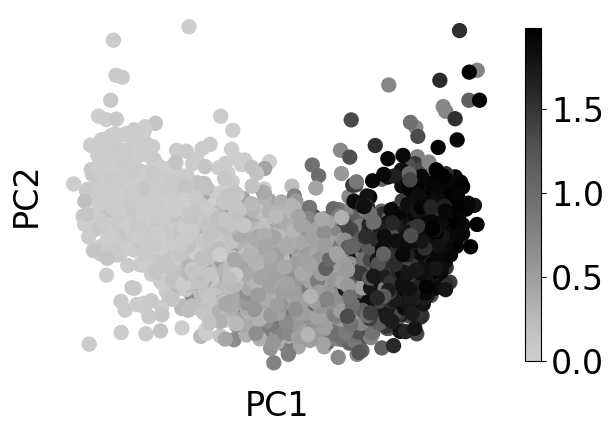

In [149]:
cmap_y = cmr.get_sub_cmap('Greys', 0.3, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj_.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

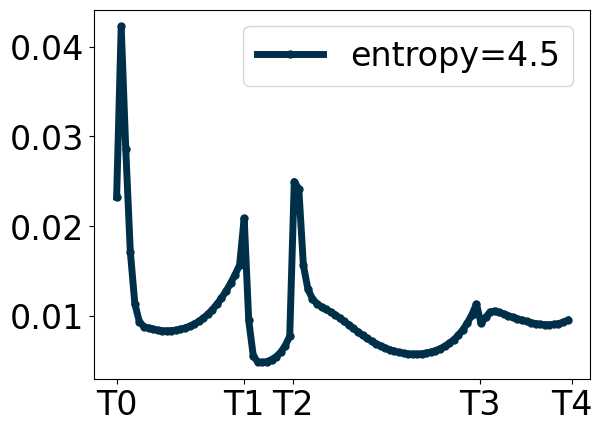

In [153]:
ax = plt.subplot()
marginal = traj_.Q.sum((0,1))/traj_.Q.sum()
ax.plot(marginal,'.-',color="#003049",linewidth=5,\
        label="entropy="+str(np.around(entropy(marginal),2)));
x_label_list = ['T0', 'T1', 'T2', 'T3', 'T4']
ax.set_xticks(traj_.tau/traj_.tau[-1]*traj_.m)
ax.set_xticklabels(x_label_list);
ax.legend()

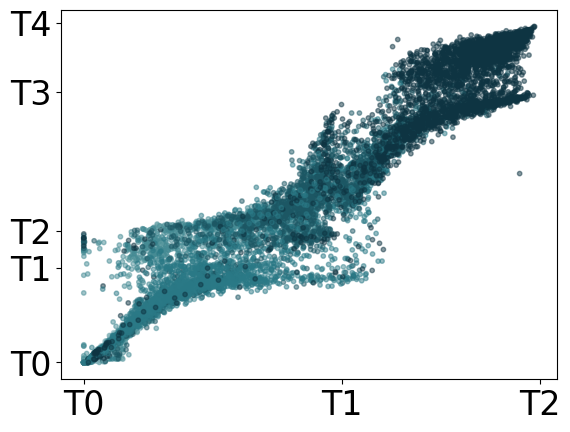

In [162]:
ax = plt.subplot()
ax.scatter(traj.Q[:,0]@traj.t,traj_.Q[:,0]@traj_.t,s=10,c=cell_colors);
x_label_list = ['T0', 'T1', 'T2']
ax.set_xticks(traj.tau)
ax.set_xticklabels(x_label_list);
y_label_list = ['T0', 'T1', 'T2', 'T3', 'T4']
ax.set_yticks(traj_.tau)
ax.set_yticklabels(y_label_list);

# Trajectory fitting on selected genes

In [199]:
X_good = X[:,good_idx]

## Random initialization

In [200]:
from multiprocessing import Pool

tau = (0,1,2)
topo = np.array([[0,1,2]])
params={'r':rd,"lambda_tau":0,"lambda_a":0}

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_good,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(25) as pool:      
    trajs_good = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [201]:
data = {'ri':trajs,'ws':traj_ws,'PM':PM,'ri_good':trajs_good}
with open('results/Erythoid.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [240]:
corrs = []
AICs = []
right_t = traj.Q.sum(1) @ trajs[0].t
for traj_ in trajs_good:
    t_hat = traj_.Q.sum(1) @ traj_.t
    corrs.append(pearsonr(right_t,t_hat)[0])
    AICs.append( traj_.compute_AIC(traj_.X, standard=True) )

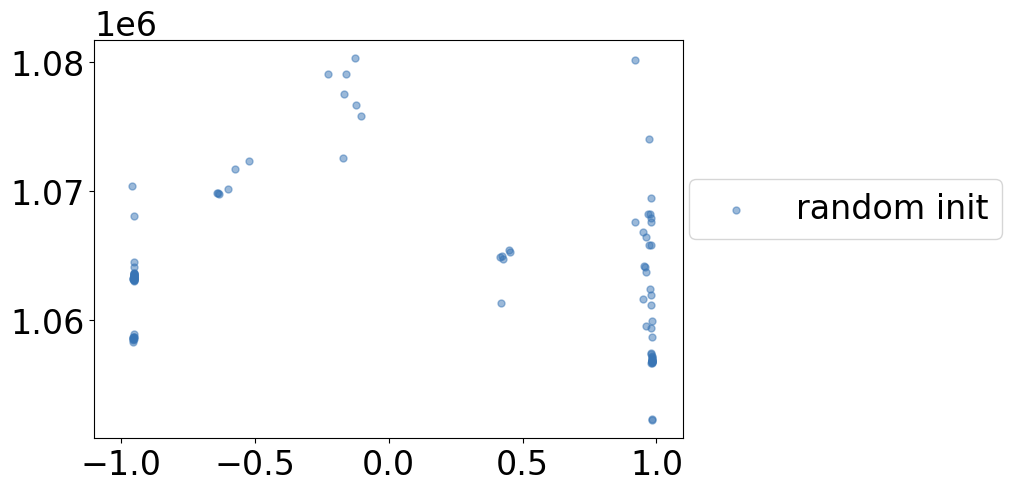

In [242]:
fig, ax = plt.subplots(1,1,figsize=(10,4.8))
plt.scatter(corrs,np.array(AICs),s=100,marker='.',color='#3975b5',alpha=0.5,label='random init')#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
plt.legend(loc=(1.01,0.5),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

## Bootstraps

In [216]:
from sklearn.utils import resample

tau = (0,1,2)
topo = np.array([[0,1,2]])
n = len(X)

Input_args = []
def fit_wrapper(seed):
    bootstrap_idx = resample(np.arange(n),replace=True,n_samples=n,random_state=seed,stratify=clusters)
    X_b = X_good[bootstrap_idx]

    params_b={'r':rd[bootstrap_idx],"lambda_tau":0,"lambda_a":0}

    traj_b = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj_b = traj_b.fit(X_b,m=100,n_init=20,params=params_b,perm_theta=False,epoch=100,parallel=False,n_threads=1)
    return (bootstrap_idx,traj_b)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    bootstraps_good = pool.starmap(fit_wrapper, Input_args, chunksize=1)

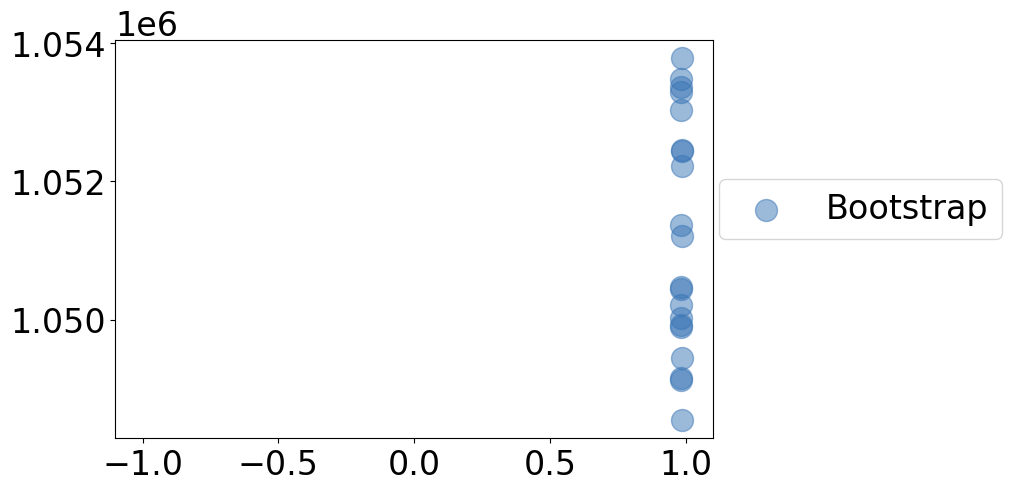

In [243]:
corrs = []
AICs = []
original_t = traj.Q.sum(1) @ traj.t
for bootstrap_idx,traj_b in bootstraps_good:
    ref_t = original_t[bootstrap_idx]
    t_hat = traj_b.Q.sum(1) @ traj_b.t
    corrs.append(pearsonr(ref_t,t_hat)[0])
    #corrs.append(np.sqrt(np.mean((ref_t-t_hat)**2)))
    AICs.append( traj_b.compute_AIC(traj_b.X, standard=True) )
fig, ax = plt.subplots(1,1,figsize=(10,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='Bootstrap')
#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
plt.legend(loc=(1.01,0.5),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

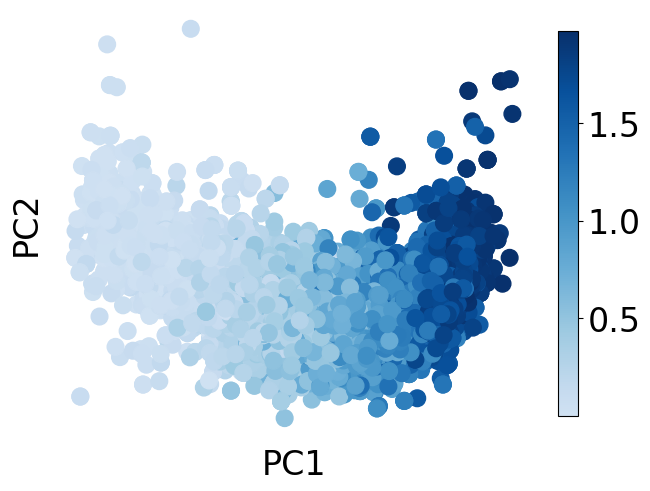

In [244]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[bootstrap_idx,0],x[bootstrap_idx,1],c=traj_b.Q.sum(1)@traj_b.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

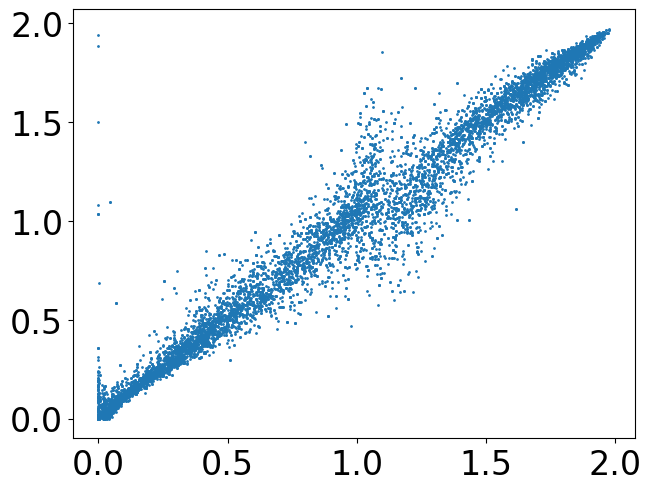

In [245]:
original_t = traj.Q.sum(1) @ traj.t
ref_t = original_t[bootstrap_idx]
t_hat = traj_b.Q.sum(1) @ traj_b.t
plt.scatter(ref_t,t_hat,s=1)

In [232]:
data = {"fitted_genes":fitted_genes,'ri':trajs,'ws':traj_ws,'PM':PM,'ri_good':trajs_good,'bs_good':bootstraps_good,'bs':bootstraps}
with open('results/Erythoid.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)